In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.regression.dimred import CORE
from scipy.linalg import eigh
from matplotlib.patches import Ellipse
from scipy.stats.distributions import chi2
from statsmodels.nonparametric.smoothers_lowess import lowess

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

C:\Users\rajnishk\AppData\Local\Temp\ipykernel_13704\3092086655.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv(r'C:\Users\rajnishk\OneDrive - Michigan Medicine\Documents\Student Wellness Dataset\student_wellness_sleep_details.csv',
                 parse_dates=["SLEEP_DATE","SLEEP_START_DATE", "SLEEP_END_DATE"])

# df = pd.read_csv("/home/kshedden/data/Sung_Choi/student_wellness/student_wellness_sleep_details.csv.gz",
#                  parse_dates=["SLEEP_DATE", "SLEEP_START_DATE", "SLEEP_END_DATE"])

Keep only the sleep-relevant variables.  Convert the sleep start time and day of year into polar coordinates.

In [3]:
sleep_vars = ['ASLEEP_VALUE', 'INBED_VALUE', 'DEEP_MIN', 'DEEP_COUNT', 'LIGHT_MIN', 'LIGHT_COUNT', 
              'REM_MIN', 'REM_COUNT', 'WAKE_MIN', 'WAKE_COUNT', 'ASLEEP_MIN', 'ASLEEP_COUNT', 
              'AWAKE_COUNT', 'AWAKE_MIN', 'RESTLESS_COUNT', 'RESTLESS_MIN']
v = df[sleep_vars].isna().sum(0)
v = v[v < 500].index.tolist()
vv = ["STUDY_PRTCPT_ID", "SLEEP_START_DATE", "SLEEP_END_DATE", "SLEEP_DATE"] + v
dx = df[vv].copy()
dx["YEARDAY"] = dx["SLEEP_DATE"].dt.dayofyear
dx["DAYOFWEEK"] = dx["SLEEP_DATE"].dt.dayofweek
dx["SLEEP_START_TIME"] = (dx["SLEEP_START_DATE"] - dx["SLEEP_START_DATE"].dt.normalize()) / pd.Timedelta(hours=1)
dx["SLEEP_END_TIME"] = (dx["SLEEP_END_DATE"] - dx["SLEEP_END_DATE"].dt.normalize()) / pd.Timedelta(hours=1)
dx["SLEEP_START_SIN"] = np.sin(2*np.pi*dx["SLEEP_START_TIME"]/24)
dx["SLEEP_START_COS"] = np.cos(2*np.pi*dx["SLEEP_START_TIME"]/24)
dx["SLEEP_END_SIN"] = np.sin(2*np.pi*dx["SLEEP_END_TIME"]/24)
dx["SLEEP_END_COS"] = np.cos(2*np.pi*dx["SLEEP_END_TIME"]/24)
dx["YEARDAY_SIN"] = np.sin(2*np.pi*dx["YEARDAY"]/366)
dx["YEARDAY_COS"] = np.cos(2*np.pi*dx["YEARDAY"]/366)

# #===============================================================================================
# dx["SLEEP_START_TIME"] = (dx["SLEEP_START_DATE"] - dx["SLEEP_START_DATE"].dt.normalize()) / pd.Timedelta(hours=1)
# plt.scatter(dx["SLEEP_START_TIME"],dx["SLEEP_START_SIN"] )
# #===============================================================================================


dx["STUDYDAY"] = dx["YEARDAY"] - dx.groupby("STUDY_PRTCPT_ID")["YEARDAY"].transform(np.min)
dx = dx.drop(columns=["SLEEP_START_DATE", "SLEEP_END_DATE", "SLEEP_START_TIME", "SLEEP_END_TIME", "SLEEP_DATE"])
dx = dx.dropna()
dx.columns

C:\Users\rajnishk\AppData\Local\Temp\ipykernel_13704\1913316844.py:25: FutureWarning: The provided callable <function min at 0x00000244DDE253A0> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  dx["STUDYDAY"] = dx["YEARDAY"] - dx.groupby("STUDY_PRTCPT_ID")["YEARDAY"].transform(np.min)


Index(['STUDY_PRTCPT_ID', 'ASLEEP_VALUE', 'INBED_VALUE', 'DEEP_MIN',
       'DEEP_COUNT', 'LIGHT_MIN', 'LIGHT_COUNT', 'REM_MIN', 'REM_COUNT',
       'WAKE_MIN', 'WAKE_COUNT', 'YEARDAY', 'DAYOFWEEK', 'SLEEP_START_SIN',
       'SLEEP_START_COS', 'SLEEP_END_SIN', 'SLEEP_END_COS', 'YEARDAY_SIN',
       'YEARDAY_COS', 'STUDYDAY'],
      dtype='object')

In [5]:
df.dtypes

Unnamed: 0                   int64
SLEEP_SUMMARY_ID             int64
STUDY_PRTCPT_ID             object
STUDY_ID                     int64
SLEEP_DATE          datetime64[ns]
SLEEP_START_DATE    datetime64[ns]
SLEEP_END_DATE      datetime64[ns]
ASLEEP_VALUE                 int64
INBED_VALUE                  int64
DEEP_MIN                   float64
DEEP_COUNT                 float64
LIGHT_MIN                  float64
LIGHT_COUNT                float64
REM_MIN                    float64
REM_COUNT                  float64
WAKE_MIN                   float64
WAKE_COUNT                 float64
ASLEEP_MIN                 float64
ASLEEP_COUNT               float64
AWAKE_COUNT                float64
AWAKE_MIN                  float64
RESTLESS_COUNT             float64
RESTLESS_MIN               float64
TYPE                        object
dtype: object

In [4]:
dx

STUDY_PRTCPT_ID  ASLEEP_VALUE  INBED_VALUE  DEEP_MIN  DEEP_COUNT  \
0           XGJ8AFS8           485          580      67.0         5.0   
1           XGJ8AFS8           587          682      59.0         6.0   
2           XGJ8AFS8           561          690      71.0         5.0   
3           XGJ8AFS8           458          508      91.0         4.0   
5           XGJ8AFS8           492          611      44.0         4.0   
...              ...           ...          ...       ...         ...   
2260        JU3R5P4M           413          482      65.0         3.0   
2261        JU3R5P4M           303          355      64.0         4.0   
2262        JU3R5P4M           191          217      25.0         1.0   
2263        JU3R5P4M           346          421      65.0         3.0   
2264        JU3R5P4M           345          417      48.0         5.0   

      LIGHT_MIN  LIGHT_COUNT  REM_MIN  REM_COUNT  WAKE_MIN  WAKE_COUNT  \
0         320.0         25.0     98.0        9.0      95.0        28.0   
1         423.0         40.0    105.0        8.0      95.0        40.0   
2         394.0         40.0     96.0        7.0     129.0        37.0   
3         243.0         31.0    124.0       11.0      50.0        33.0   
5         360.0         30.0     88.0        9.0     119.0        29.0   
...         ...          ...      ...        ...       ...         ...   
2260      277.0         35.0     71.0        8.0      69.0        36.0   
2261      179.0         17.0     60.0        5.0      52.0        15.0   
2262      161.0         22.0      5.0        1.0      26.0        20.0   
2263      229.0         25.0     52.0        2.0      75.0        21.0   
2264      275.0         29.0     22.0        4.0      72.0        31.0   

      YEARDAY  DAYOFWEEK  SLEEP_START_SIN  SLEEP_START_COS  SLEEP_END_SIN  \
0          21          5        -0.848048         0.529919       0.998741   
1          22          6        -0.783964         0.620806       0.875675   
2          23          0        -0.910864         0.412707       0.956940   
3          24          1        -0.594823         0.803857       0.999941   
5          25          2        -0.817899         0.575362       0.990268   
...       ...        ...              ...              ...            ...   
2260      122          1         0.492424         0.870356       0.500000   
2261      123          2         0.608761         0.793353       0.805153   
2262      123          2        -0.760406        -0.649448      -0.971342   
2263      124          3         0.987688         0.156434      -0.111035   
2264      125          4         0.774393         0.632705       0.420640   

      SLEEP_END_COS  YEARDAY_SIN  YEARDAY_COS  STUDYDAY  
0          0.050157     0.352752     0.935717         0  
1         -0.482900     0.368763     0.929523         1  
2         -0.290285     0.384665     0.923056         2  
3         -0.010908     0.400454     0.916317         3  
5         -0.139173     0.416125     0.909308         4  
...             ...          ...          ...       ...  
2260      -0.866025     0.866025    -0.500000        36  
2261      -0.593068     0.857315    -0.514793        37  
2262       0.237686     0.857315    -0.514793        37  
2263      -0.993816     0.848351    -0.529434        38  
2264      -0.907228     0.839138    -0.543919        39  

[1810 rows x 20 columns]

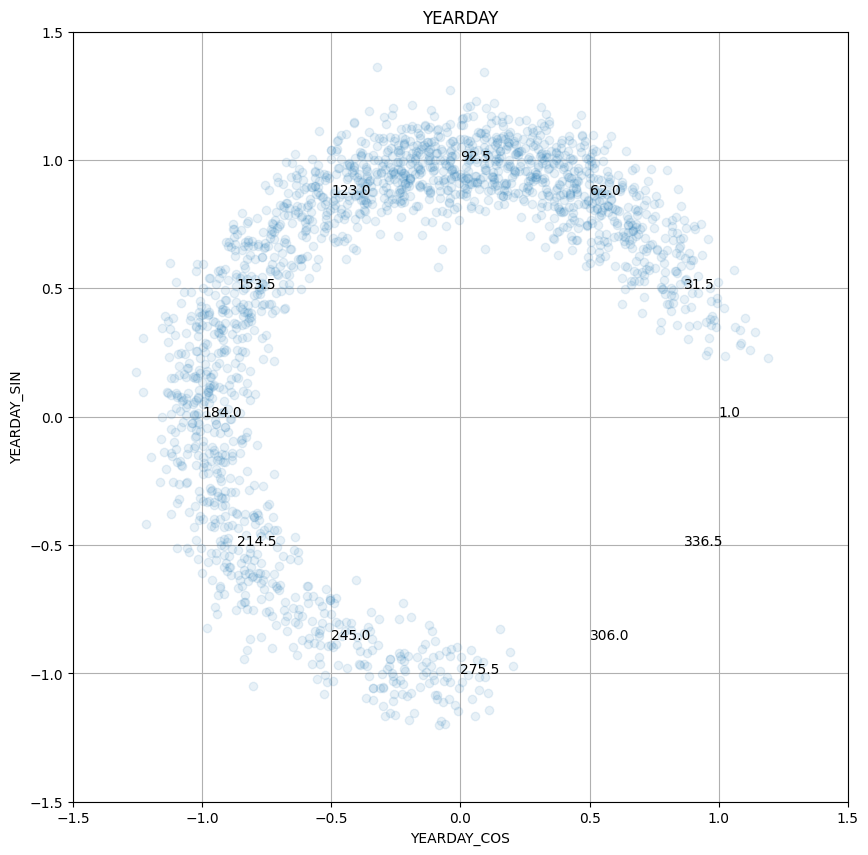

In [5]:
plt.clf()
plt.title("YEARDAY")
plt.xlabel("YEARDAY_COS")
plt.ylabel("YEARDAY_SIN")
plt.grid(True)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
e1 = 0.1*np.random.normal(size=dx.shape[0])
e2 = 0.1*np.random.normal(size=dx.shape[0])
plt.plot(dx["YEARDAY_COS"]+e1, dx["YEARDAY_SIN"]+e2, "o", alpha=0.1)
for i in range(12):
    x = np.cos(2*np.pi*i*30.5/366)
    y = np.sin(2*np.pi*i*30.5/366)
    # plt.text(x, y, str(i+1))
    plt.text(x, y, str(30.5*i + 1))
plt.show()

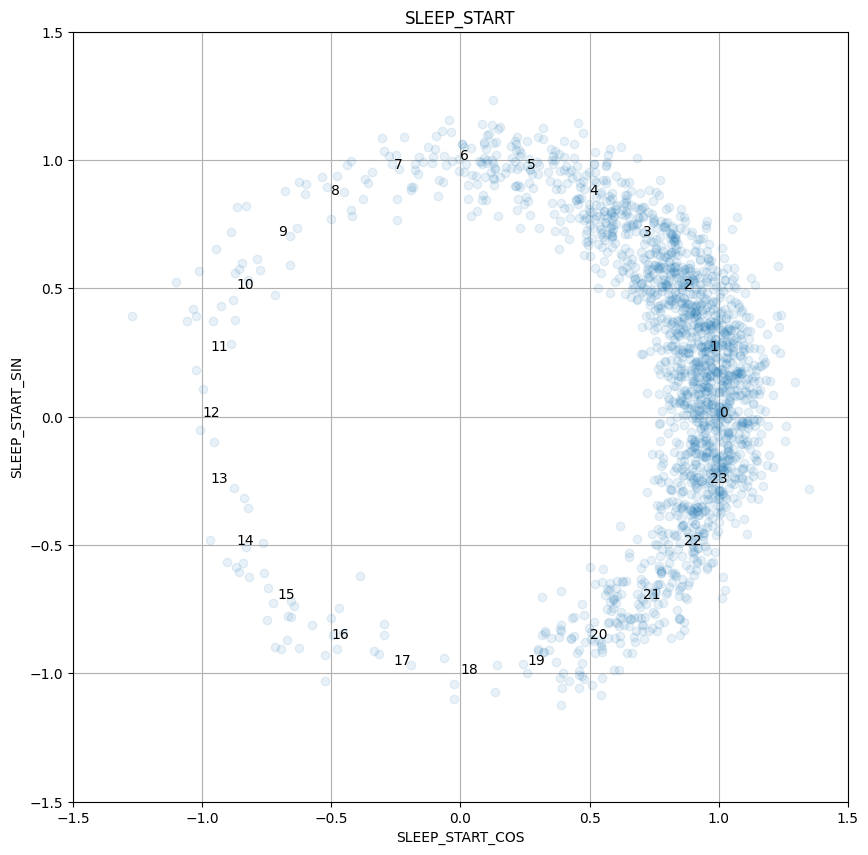

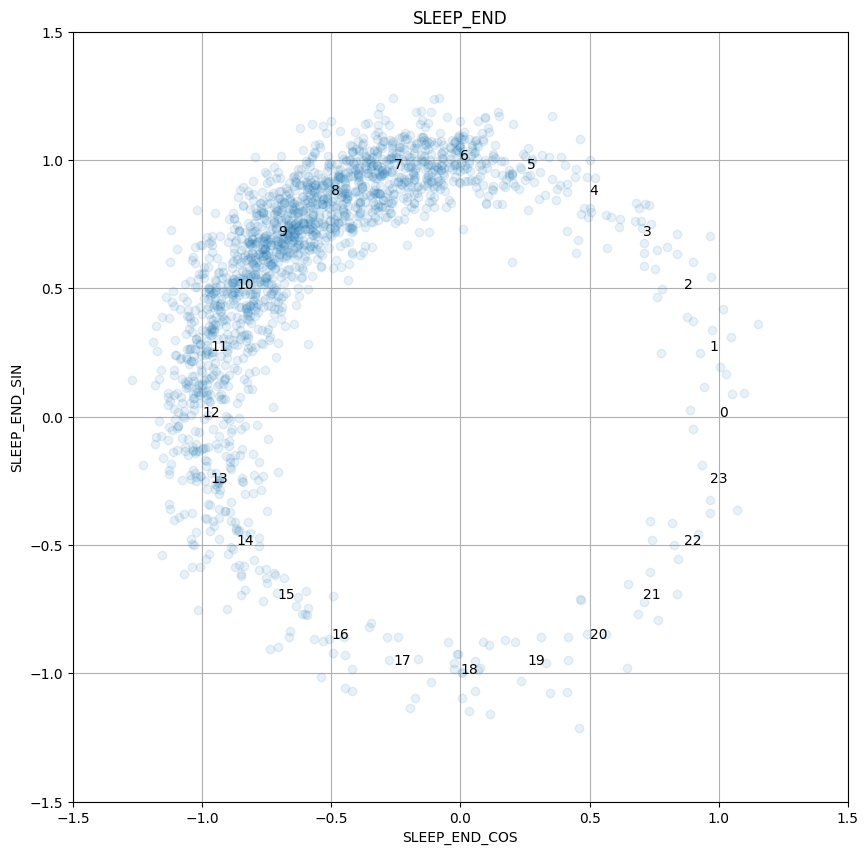

In [6]:
def plot_clock(vn):
    plt.clf()
    plt.title(vn)
    plt.xlabel("%s_COS" % vn)
    plt.ylabel("%s_SIN" % vn)
    plt.grid(True)
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    e1 = 0.1*np.random.normal(size=dx.shape[0])
    e2 = 0.1*np.random.normal(size=dx.shape[0])
    plt.plot(dx["%s_COS" % vn]+e1, dx["%s_SIN" % vn]+e2, "o", alpha=0.1)
    for i in range(24):
        x = np.cos(2*np.pi*i/24)
        y = np.sin(2*np.pi*i/24)
        plt.text(x, y, str(i))
    plt.show()
    
plot_clock("SLEEP_START")
plot_clock("SLEEP_END")

Standardize the sleep variables.

In [7]:
exclude = ["STUDY_PRTCPT_ID", "STUDYDAY", "YEARDAY", "DAYOFWEEK"]
va = [x for x in dx.columns if x not in exclude]
print("va is %s" %va)
dx[va] = dx[va] - dx[va].mean(0)
dx[va] = dx[va] / dx[va].std(0)
# dx["STUDY_PRTCPT_ID"].value_counts()

va is ['ASLEEP_VALUE', 'INBED_VALUE', 'DEEP_MIN', 'DEEP_COUNT', 'LIGHT_MIN', 'LIGHT_COUNT', 'REM_MIN', 'REM_COUNT', 'WAKE_MIN', 'WAKE_COUNT', 'SLEEP_START_SIN', 'SLEEP_START_COS', 'SLEEP_END_SIN', 'SLEEP_END_COS', 'YEARDAY_SIN', 'YEARDAY_COS']


In [8]:
dx

STUDY_PRTCPT_ID  ASLEEP_VALUE  INBED_VALUE  DEEP_MIN  DEEP_COUNT  \
0           XGJ8AFS8      0.689058     0.879739 -0.149309    0.874792   
1           XGJ8AFS8      1.584501     1.661502 -0.436387    1.528000   
2           XGJ8AFS8      1.356250     1.722817 -0.005769    0.874792   
3           XGJ8AFS8      0.452028     0.327907  0.711927    0.221585   
5           XGJ8AFS8      0.750510     1.117334 -0.974659    0.221585   
...              ...           ...          ...       ...         ...   
2260        JU3R5P4M      0.056980     0.128634 -0.221078   -0.431622   
2261        JU3R5P4M     -0.908694    -0.844737 -0.256963    0.221585   
2262        JU3R5P4M     -1.891925    -1.902417 -1.656471   -1.738036   
2263        JU3R5P4M     -0.531203    -0.338891 -0.221078   -0.431622   
2264        JU3R5P4M     -0.539982    -0.369548 -0.831120    0.874792   

      LIGHT_MIN  LIGHT_COUNT   REM_MIN  REM_COUNT  WAKE_MIN  WAKE_COUNT  \
0      0.984194    -0.149546  0.200308   0.258881  1.567300    0.143813   
1      2.333198     1.439566  0.387124   0.006688  1.567300    1.346132   
2      1.953381     1.439566  0.146932  -0.245505  3.023174    1.045552   
3     -0.024284     0.486099  0.894196   0.763268 -0.359592    0.644779   
5      1.508079     0.380158 -0.066573   0.258881  2.594976    0.244006   
...         ...          ...       ...        ...       ...         ...   
2260   0.421018     0.909862 -0.520269   0.006688  0.453985    0.945359   
2261  -0.862500    -0.997073 -0.813837  -0.749892 -0.273952   -1.158699   
2262  -1.098248    -0.467369 -2.281679  -1.758666 -1.387268   -0.657733   
2263  -0.207644    -0.149546 -1.027341  -1.506472  0.710904   -0.557539   
2264   0.394824     0.274217 -1.827982  -1.002085  0.582444    0.444393   

      YEARDAY  DAYOFWEEK  SLEEP_START_SIN  SLEEP_START_COS  SLEEP_END_SIN  \
0          21          5        -1.940444        -0.491676       0.917389   
1          22          6        -1.818762        -0.266209       0.660492   
2          23          0        -2.059717        -0.782451       0.830130   
3          24          1        -1.459622         0.187896       0.919892   
5          25          2        -1.883196        -0.378944       0.899701   
...       ...        ...              ...              ...            ...   
2260      122          1         0.604831         0.352863      -0.123722   
2261      123          2         0.825732         0.161839       0.513277   
2262      123          2        -1.774030        -3.417397      -3.195116   
2263      124          3         1.545235        -1.418200      -1.399245   
2264      125          4         1.140231        -0.236689      -0.289384   

      SLEEP_END_COS  YEARDAY_SIN  YEARDAY_COS  STUDYDAY  
0          1.353460    -0.144576     2.030831         0  
1          0.101336    -0.119515     2.020145         1  
2          0.553780    -0.094624     2.008986         2  
3          1.210021    -0.069911     1.997358         3  
5          0.908733    -0.045382     1.985264         4  
...             ...          ...          ...       ...  
2260      -0.798605     0.658821    -0.446398        36  
2261      -0.157441     0.645186    -0.471922        37  
2262       1.793956     0.645186    -0.471922        37  
2263      -1.098779     0.631156    -0.497184        38  
2264      -0.895386     0.616735    -0.522177        39  

[1810 rows x 20 columns]

v is ['ASLEEP_VALUE', 'INBED_VALUE', 'DEEP_MIN', 'DEEP_COUNT', 'LIGHT_MIN', 'LIGHT_COUNT', 'REM_MIN', 'REM_COUNT', 'WAKE_MIN', 'WAKE_COUNT']


<Axes: >

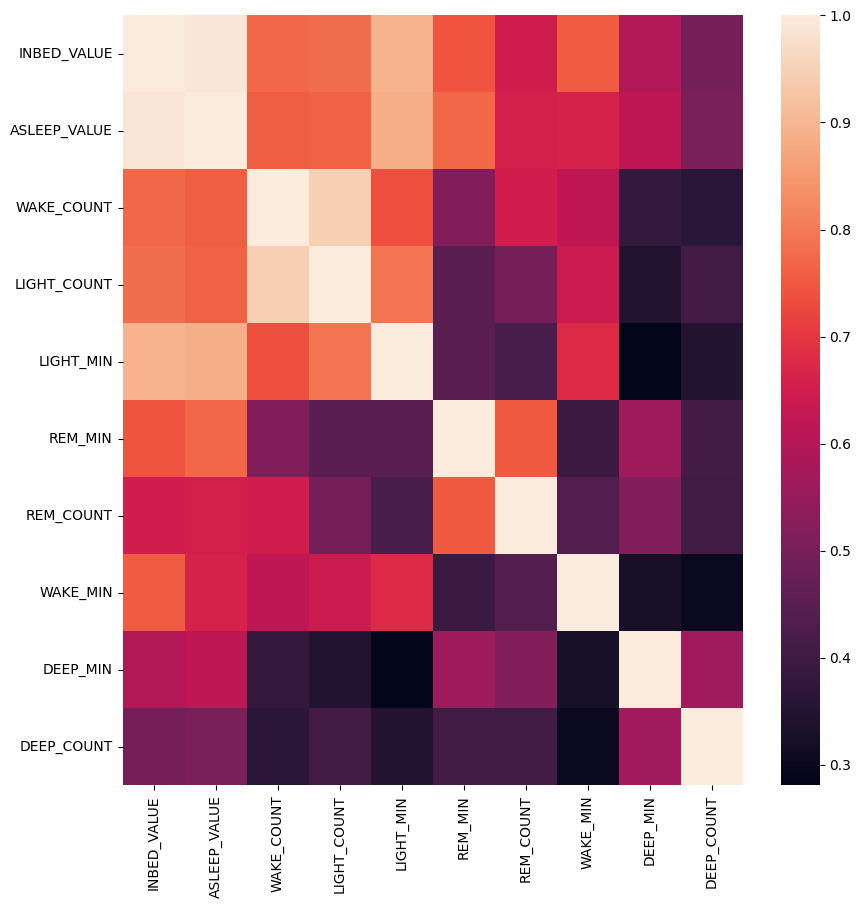

In [9]:
v = [x for x in va if not (x.endswith("_SIN") or x.endswith("_COS"))]
print("v is %s" %v)
X = dx[v].copy()
X0 = X - X.mean(0)     # We might not need this. COnfirm it with Dr. Shedden. The means will be zero anyway because of the standardization.  
# X0  = X
C = X0.corr()
a, b = eigh(C)
ii = np.argmax(a)
jj = np.argsort(b[:, ii])
X0 = X0.iloc[:, jj]
sns.heatmap(X0.corr())
# print(X.mean(0))

Plot histograms of each sleep variable.

In [10]:
# for v in va + ["YEARDAY"]:
#     plt.figure(figsize = (6,4))
#     plt.hist(dx[v], bins=15, alpha=0.3)
#     plt.title(v)
#     plt.show()
va

['ASLEEP_VALUE',
 'INBED_VALUE',
 'DEEP_MIN',
 'DEEP_COUNT',
 'LIGHT_MIN',
 'LIGHT_COUNT',
 'REM_MIN',
 'REM_COUNT',
 'WAKE_MIN',
 'WAKE_COUNT',
 'SLEEP_START_SIN',
 'SLEEP_START_COS',
 'SLEEP_END_SIN',
 'SLEEP_END_COS',
 'YEARDAY_SIN',
 'YEARDAY_COS']

# PCA/biplots

In [11]:
def plot_eigs(eigs):
    jj = np.arange(1, len(eigs) + 1)
    ii = np.flatnonzero(eigs >= 1e-10)
    plt.clf()
    plt.grid(True)
#     plt.plot(np.log(jj[ii]), np.log(eigs[ii]), "-o")
#     plt.plot((jj[ii]), np.log(eigs[ii]), "-o")
    plt.plot((jj[ii]), (eigs[ii]), "-o")
    
    plt.ylabel("Log eigenvalue", size=15)
#     plt.xlabel("Log position", size=15)
    plt.xlabel(" position", size=15)
    plt.show()

In [12]:
def varimax(X, eps=1e-05, maxiter=1000):
    G = X.copy()
    m, p = G.shape
    Q = np.eye(p)
    if p < 2: 
        return G, Q
    d = 0.0
    for i in range(maxiter):
        z = np.dot(G, Q)
        cs = (z**2).sum(0)
        B = np.dot(G.T, z**3 - z * (cs / m))
        u, s, vt = np.linalg.svd(B, 0)
        Q = np.dot(u, vt)
        dlast = d
        d = s.sum()
        if d < dlast * (1 + eps): 
            break
            
    G = np.dot(G, Q)
    return G, Q

In [13]:
def ellipse_plot(U, idx, j0, j1):
    r2 = chi2(2).ppf(0.95)
    rr = np.sqrt(r2)
    dx = pd.DataFrame({"u0": U[:, 0], "u1": U[:, 1], "id": idx})
    plt.clf()
    plt.figure(figsize=(10, 10))
    plt.grid(True)
    plt.plot(dx["u0"], dx["u1"], "o", color="black", alpha=0.05)
    for (ky,dg) in dx.groupby("id"):
        if dg.shape[0] > 10:
            m0, m1 = dg["u0"].mean(), dg["u1"].mean()
            C = np.cov(dg["u0"], dg["u1"])
            a, b = eigh(C)
            plt.plot([m0], [m1], "o", color="blue", ms=8, alpha=0.2)
            ang = np.arctan2(b[1, 1], b[0, 1])*360/(2*np.pi)
            E = Ellipse(xy=[m0,m1], width=rr*np.sqrt(a[1]), height=rr*np.sqrt(a[0]), fc="none", ec="black", angle=ang)
            plt.gca().add_artist(E)
    plt.xlabel("Component %d" % j0, size=17)
    plt.ylabel("Component %d" % j1, size=17)
    plt.show()

va is ['ASLEEP_VALUE', 'INBED_VALUE', 'DEEP_MIN', 'DEEP_COUNT', 'LIGHT_MIN', 'LIGHT_COUNT', 'REM_MIN', 'REM_COUNT', 'WAKE_MIN', 'WAKE_COUNT', 'SLEEP_START_SIN', 'SLEEP_START_COS', 'SLEEP_END_SIN', 'SLEEP_END_COS', 'YEARDAY_SIN', 'YEARDAY_COS']


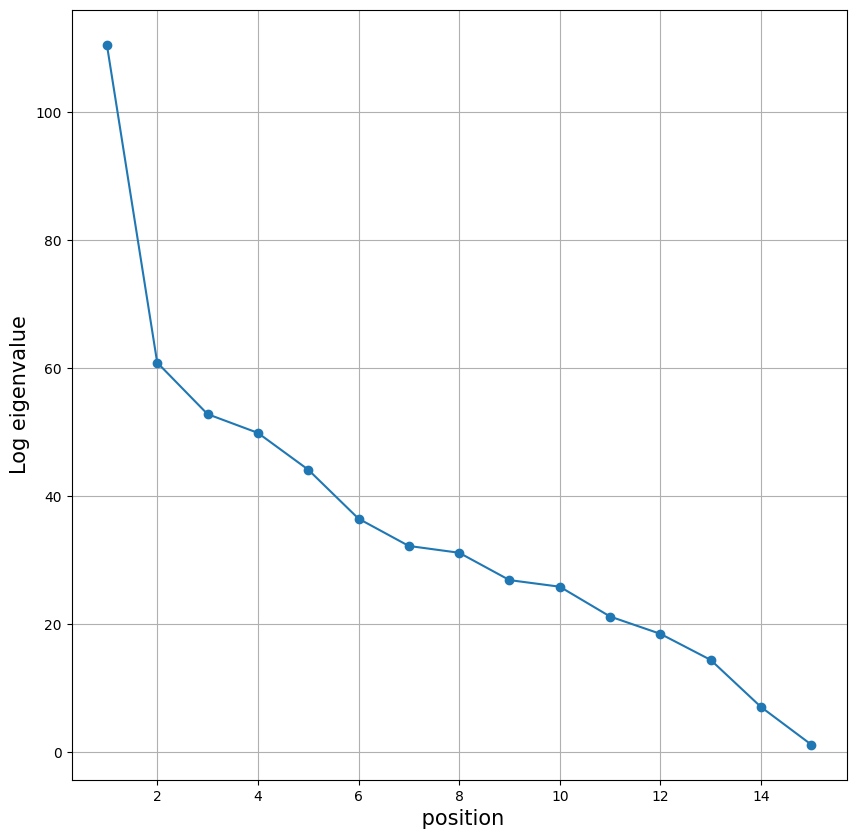

<Figure size 1000x1000 with 0 Axes>

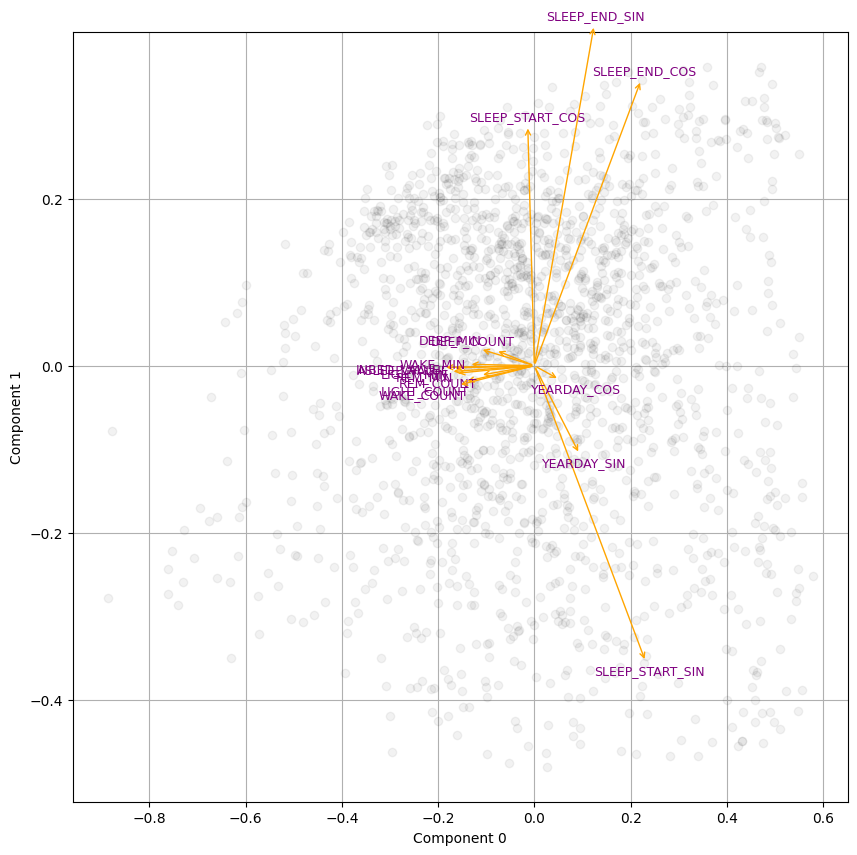

<Figure size 1000x1000 with 0 Axes>

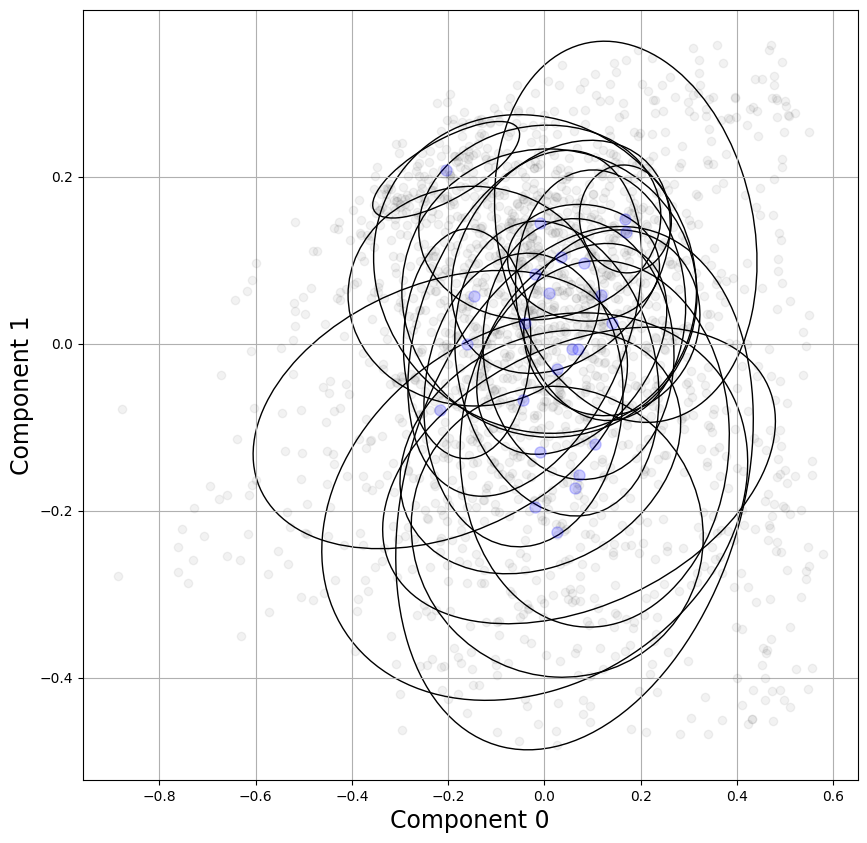

<Figure size 1000x1000 with 0 Axes>

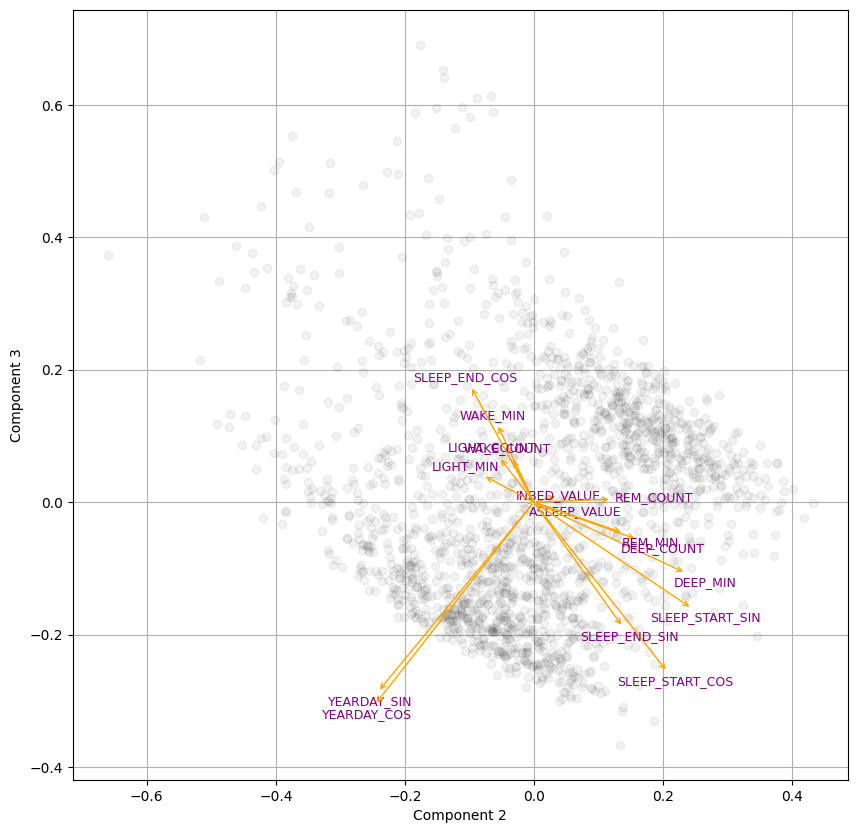

<Figure size 1000x1000 with 0 Axes>

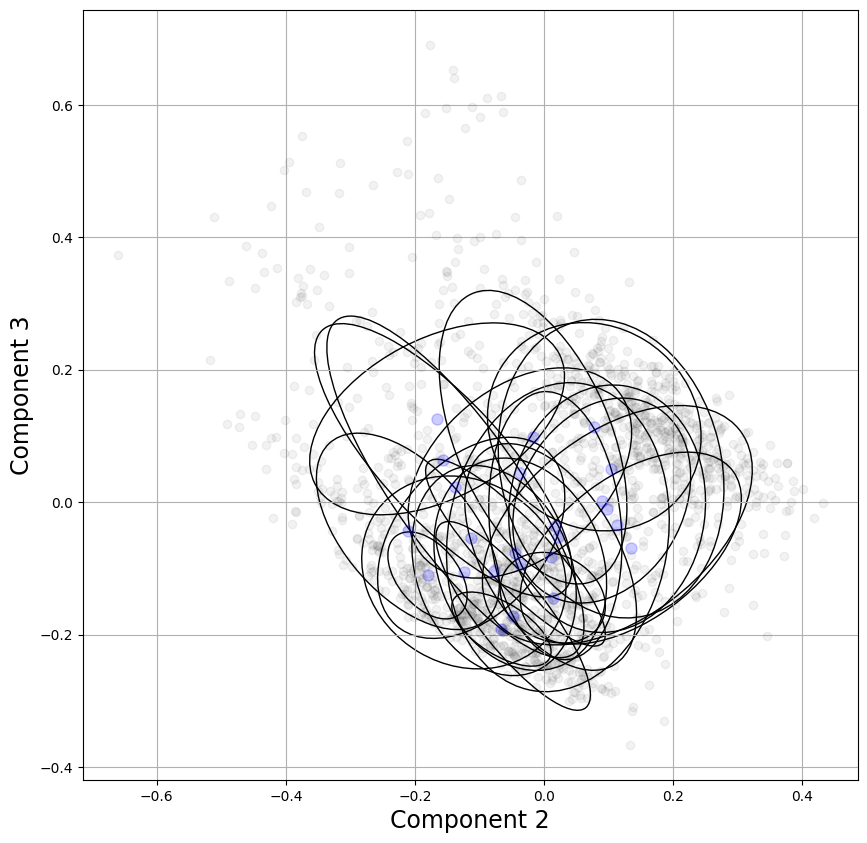

<Figure size 1000x1000 with 0 Axes>

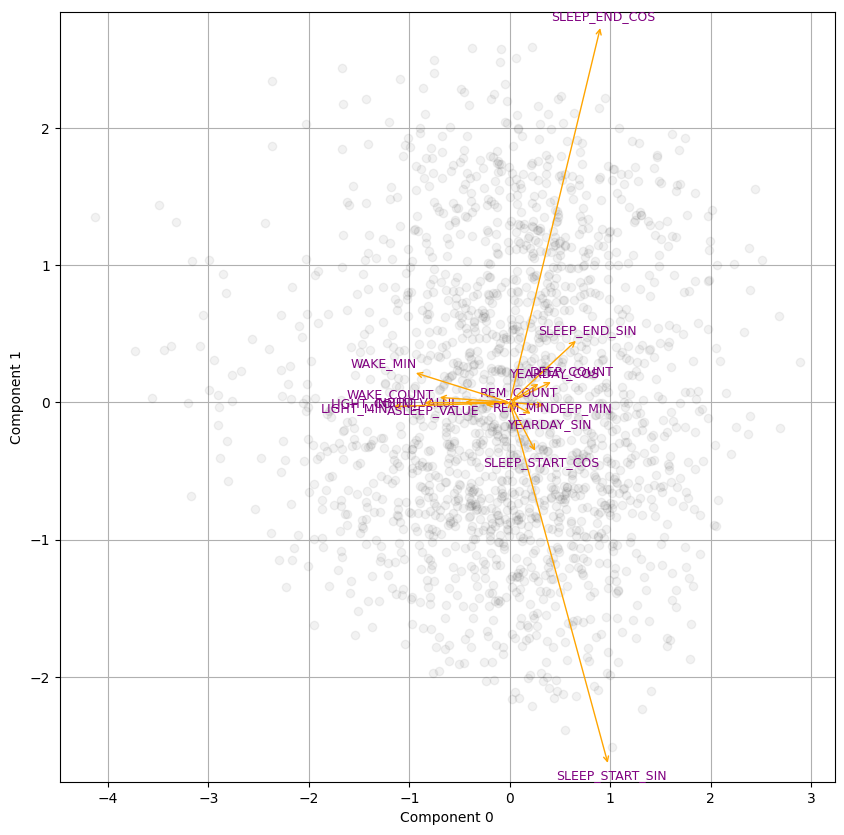

<Figure size 1000x1000 with 0 Axes>

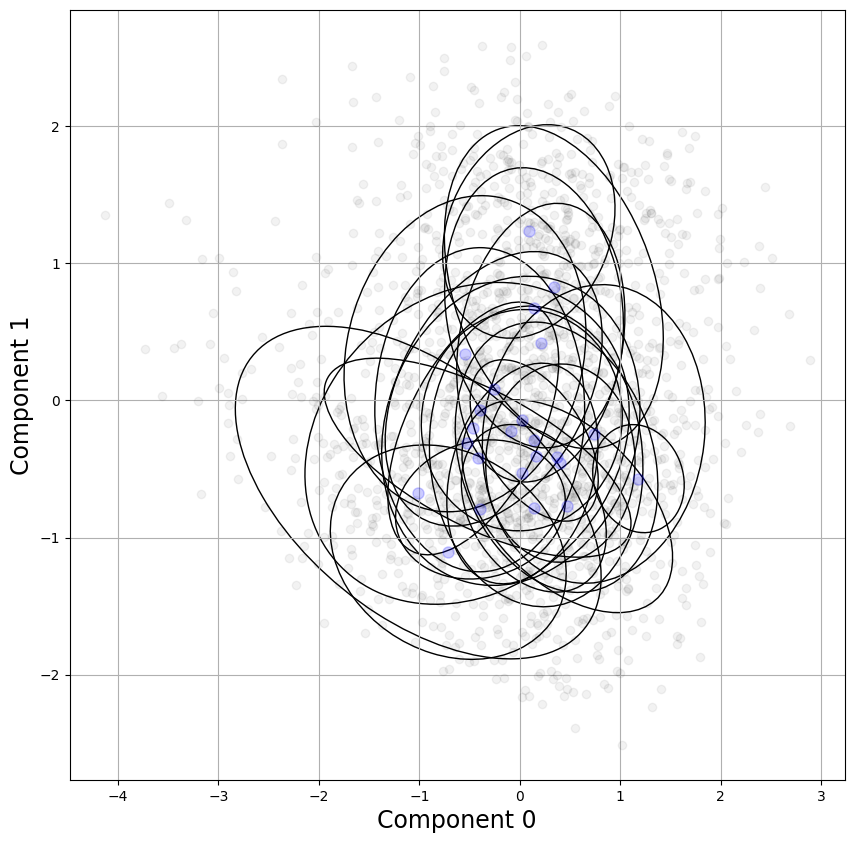

<Figure size 1000x1000 with 0 Axes>

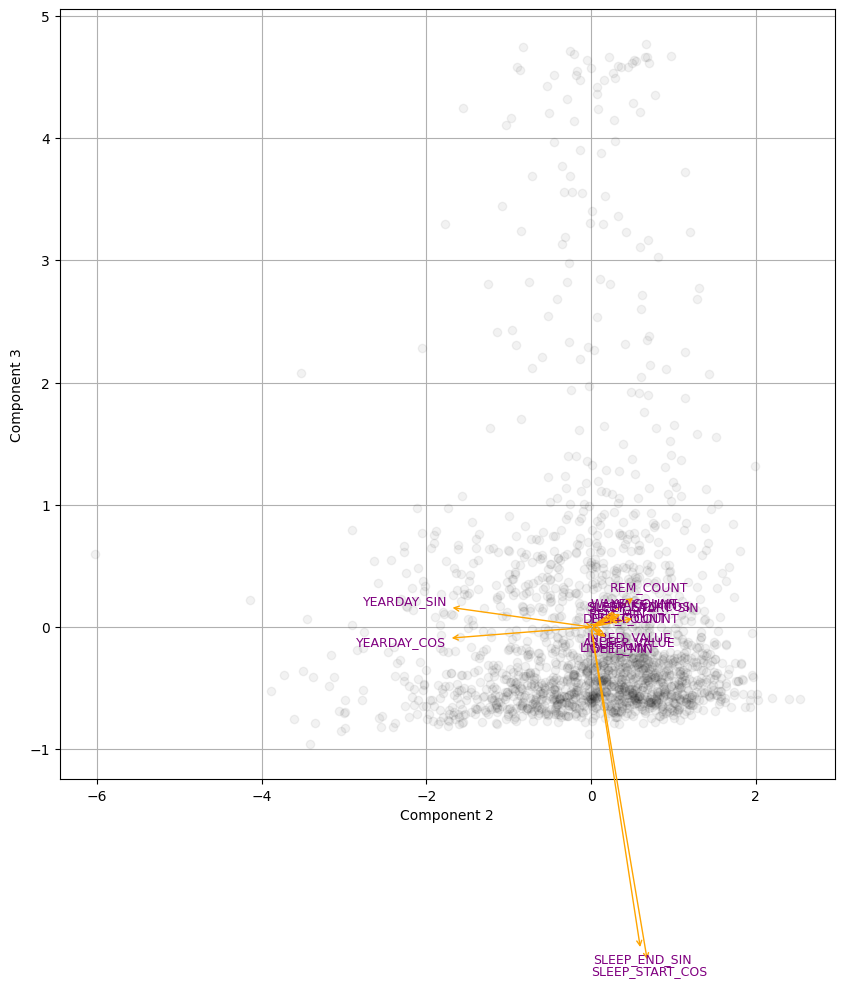

<Figure size 1000x1000 with 0 Axes>

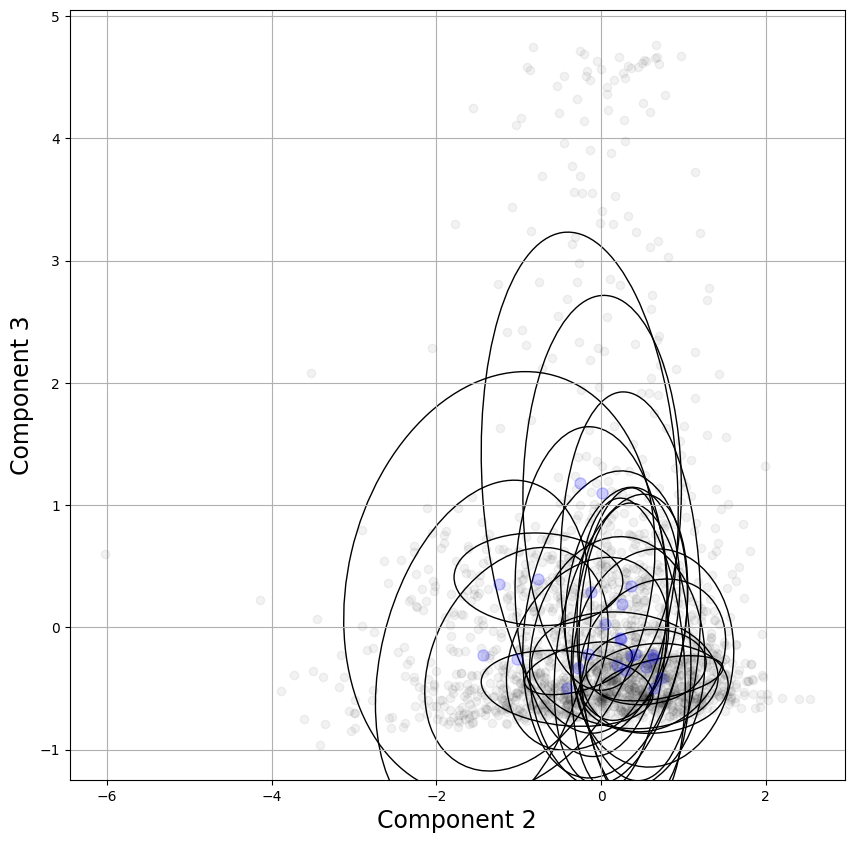

In [14]:
def biplot(dx, va, j=0, k=1, d=5, rotate=False, scree=False, ellipses=False):
    assert d > max(j, k)
    dx = dx.copy()
    X = np.asarray(dx[va])
    n, p = X.shape
    X -= X.mean()
    X -= X.mean(0)
    u, s, vt = np.linalg.svd(X, 0)
    v = vt.T
    if scree:
        plot_eigs(s)
    uu = u[:, 0:d]
    vv = v[:, 0:d]
    ss = s[0:d]
    if rotate:
        uu, Ru = varimax(uu)
        uu *= np.sqrt(n)
        vv, Rv = varimax(vv)
        vv *= np.sqrt(p)
        B = np.dot(Ru.T * ss, Rv) / np.sqrt(n*p)
    else:
        uu *= (ss**0.5)
        vv *= (ss**0.5)
        B = np.eye(d)
        
    ff = np.sqrt(X.shape[0] / X.shape[1]) # May need to adjust this
    v /= ff
    plt.clf()
    plt.figure(figsize=(10, 10))
    plt.grid(True)
    plt.plot(uu[:, j], uu[:, k], "o", color="black", alpha=0.05)
    for i in range(v.shape[0]):
        plt.annotate(va[i], xy=(0, 0), xytext=(vv[i, j], vv[i, k]), 
                     arrowprops=dict(color='orange', arrowstyle="<-"), color="purple", size=9)
    plt.xlabel("Component %d" % j)
    plt.ylabel("Component %d" % k)
    plt.show()
    
    if ellipses:
        ellipse_plot(uu[:, [j, k]], dx["STUDY_PRTCPT_ID"], j,k)
print("va is %s" %va)        
biplot(dx, va, 0, 1, d=5, rotate=False, scree=True, ellipses=True)
biplot(dx, va, 2, 3, d=5, rotate=False, ellipses=True)
biplot(dx, va, 0, 1, d=5, rotate=True, ellipses=True)
biplot(dx, va, 2, 3, d=5, rotate=True, ellipses=True)

# MANOVA

Use multivariate analysis of variance (MANOVA) to understand the between-subject and within-subject differences.

In [15]:
def manova1(dx, va, grp):
    """
    Run MANOVA on the data in dx[va], which have been centered.  The groups are
    defined by the column dx[grp].
    
    Returns:
    - H : Scaled estimate of Cov E[X|g]
    - E : Scaled estimate of E Cov[X|g]
    - ee : eigenvalues of E^-1 H
    - B : eigenvectors of E^-1 H
    - (pillai, trace, lawley, roy) : fit statistics
    """
    dg = dx.groupby(grp)[va]
    X = dx[va].values
    w = dg.size()
    M = dg.mean()
    assert all(w.index == M.index)
    w = w.values
    M = M.values
    Mw = np.sqrt(w)[:, None] * M
    H = np.dot(Mw.T, Mw)
    E = np.dot(X.T, X) - H
    ee, B = eigh(H, E)
    if ee.min() < 0:
        raise ValueError("Negative eigenvalue in MANOVA")
    ii = np.argsort(-ee)
    ee = ee[ii]
    B = B[:, ii]
    pillai = np.sum(ee / (1 + ee))
    lawley = np.sum(ee)
    wilks = np.prod(1 / (1 + ee))
    roy = ee[0] / (1 + ee[0])
    return H, E, ee, B, (pillai, lawley, wilks, roy)

In [16]:
def manova(dx, va, grp, nrep=1000, center=True):
    """
    Run MANOVA on the data in X, using randomization to calibrate the statistics.
    
    Returns:
    - H : Scaled estimate of Cov E[X|g]
    - E : Scaled estimate of E Cov[X|g]
    - ee : eigenvalues of E^-1 H
    - B : eigenvectors of E^-1 H
    - (pillai, trace, lawley, roy) : fit statistics
    - stats0 : each row is a randomized realization of the fit statistics
    """
    dx = dx.copy()
    if center:
        dx[va] = dx[va] - dx[va].mean(0)
    X = dx[va].values
    a, _ = np.linalg.eigh(np.cov(X.T))
    if a.min() <= 1e-8:
        raise ValueError("The marginal covariance matrix is singular")
    n = dx.shape[0]
    H, E, ee, B, stats = manova1(dx, va, grp)
    stats0 = np.empty((nrep, 4))
    for i in range(nrep):
        dx[grp] = dx[grp].sample(frac=1).values
        _, _, _, _, s = manova1(dx, va, grp)
        stats0[i, :] = s
        
    return X, H, E, ee, B, stats, stats0

Transform the MANOVA summary statistics to make them more interpretable.

In [17]:
def xstat_manova(stats, stats0, p):
    stats = np.copy(stats)
    stats0 = np.copy(stats0)
    # Pillai becomes the mean PVE
    stats[0] /= p
    stats0[:, 0] /= p
    # Lawley becomes the mean SNR
    stats[1] /= p
    stats0[:, 1] /= p
    # Wilks becomes the geometric mean of 1 - PVE
    stats[2] = np.power(stats[2], 1/p)
    stats0[:, 2] = np.power(stats0[:, 2], 1/p)
    # Not sure what to do with this...
    stats[3] = np.power(stats[3], 1/p)
    stats0[:, 3] = np.power(stats0[:, 3], 1/p)
    return stats, stats0

Run the MANOVA to assess inter-subject differences.  ASLEEP_VALUE is redundant so drop it here.

In [18]:
va1 = [x for x in va if x not in ["ASLEEP_VALUE", "SLEEP_END_SIN", "SLEEP_END_COS"]]
print("va1 is %s" %va1)
print("shape of dx is", np.shape(dx))
X0, H, E, ee, B, stats, stats0 = manova(dx, va1, "STUDY_PRTCPT_ID")
statsx, stats0x = xstat_manova(stats, stats0, len(va))

va1 is ['INBED_VALUE', 'DEEP_MIN', 'DEEP_COUNT', 'LIGHT_MIN', 'LIGHT_COUNT', 'REM_MIN', 'REM_COUNT', 'WAKE_MIN', 'WAKE_COUNT', 'SLEEP_START_SIN', 'SLEEP_START_COS', 'YEARDAY_SIN', 'YEARDAY_COS']
shape of dx is (1810, 20)


Plot the summary statistics.

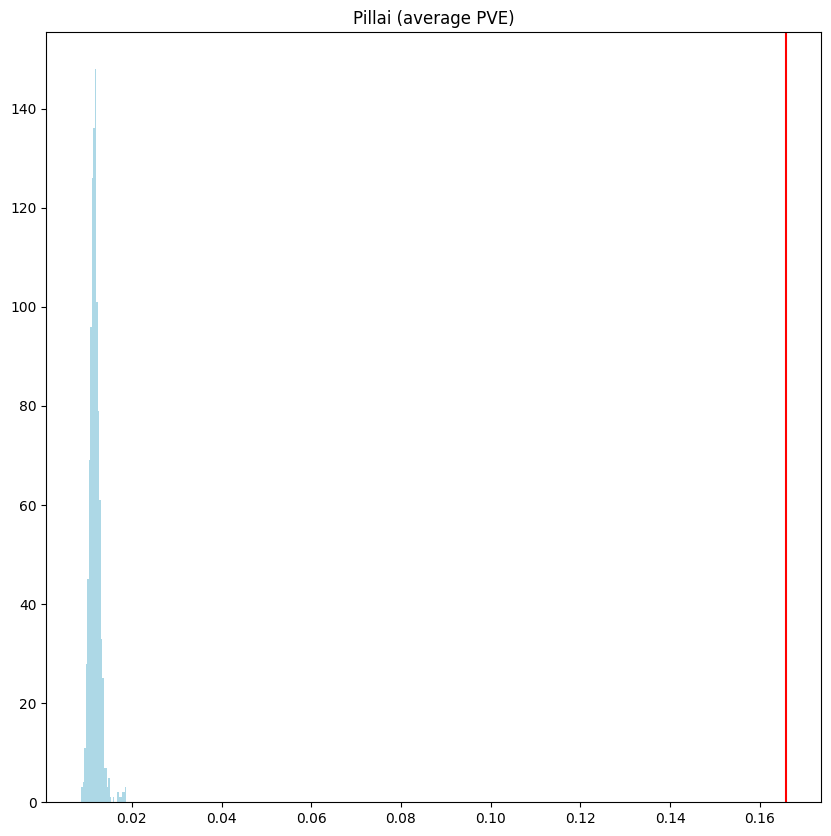

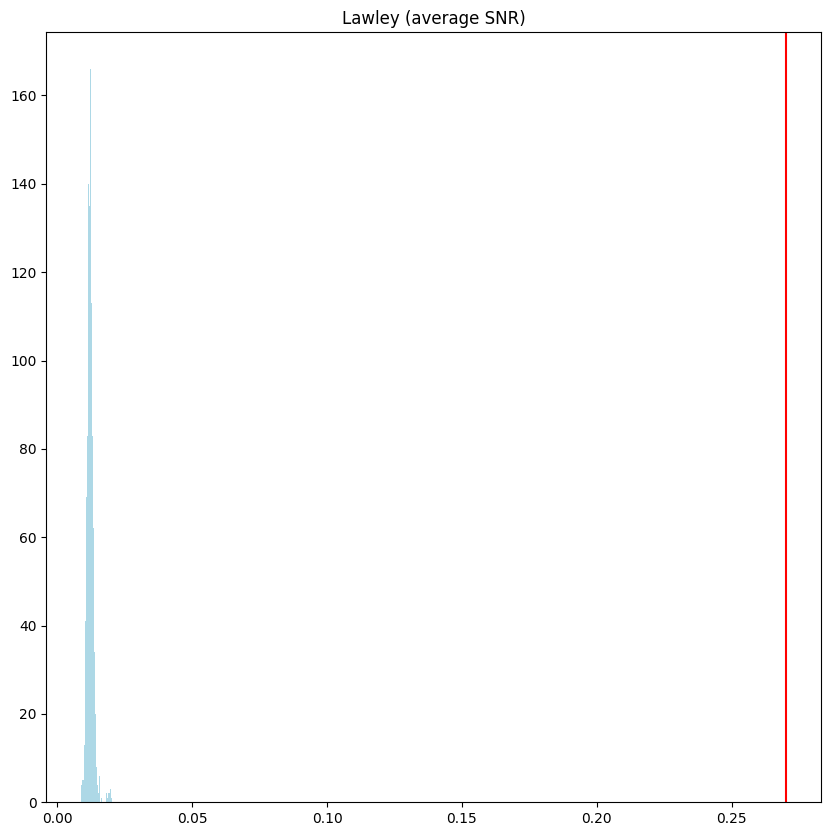

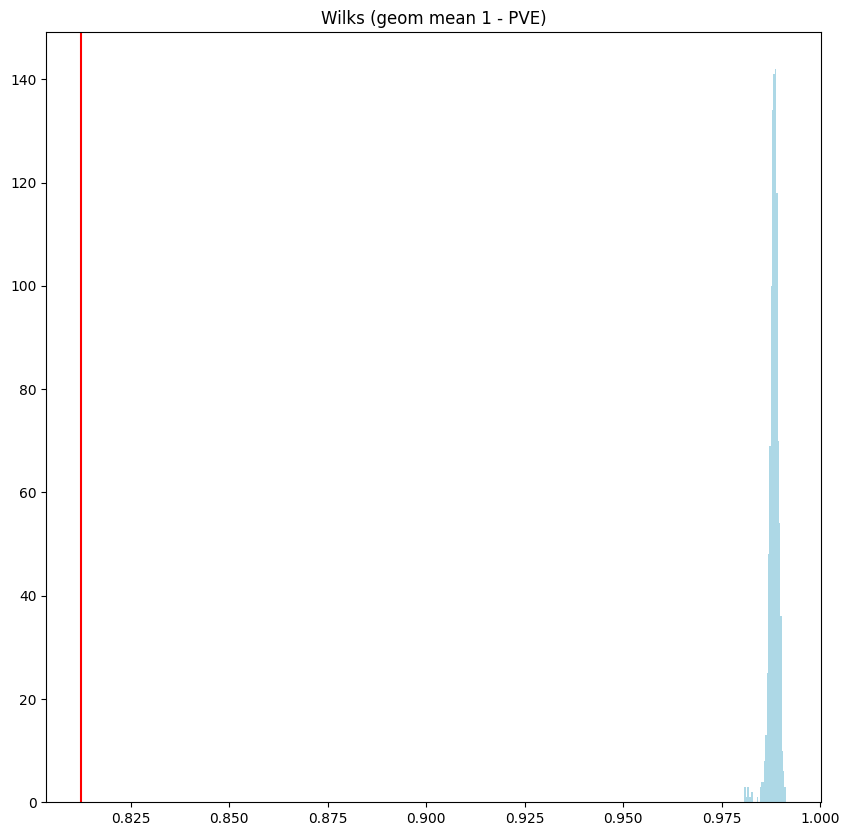

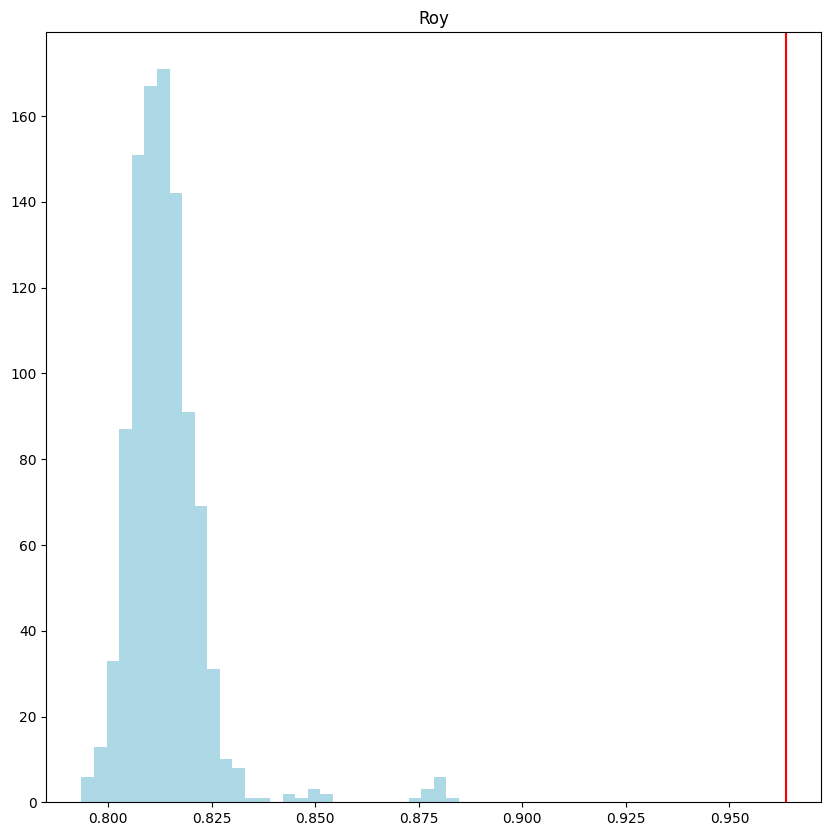

In [19]:
for (k, ti) in enumerate(["Pillai (average PVE)", "Lawley (average SNR)", "Wilks (geom mean 1 - PVE)", "Roy"]):
    plt.hist(stats0x[:, k], bins=30, color="lightblue")
    plt.axvline(statsx[k], color="red")
    plt.title(ti)
    plt.show()

Generate biplots to show how the MANOVA factors relate to the observed variables

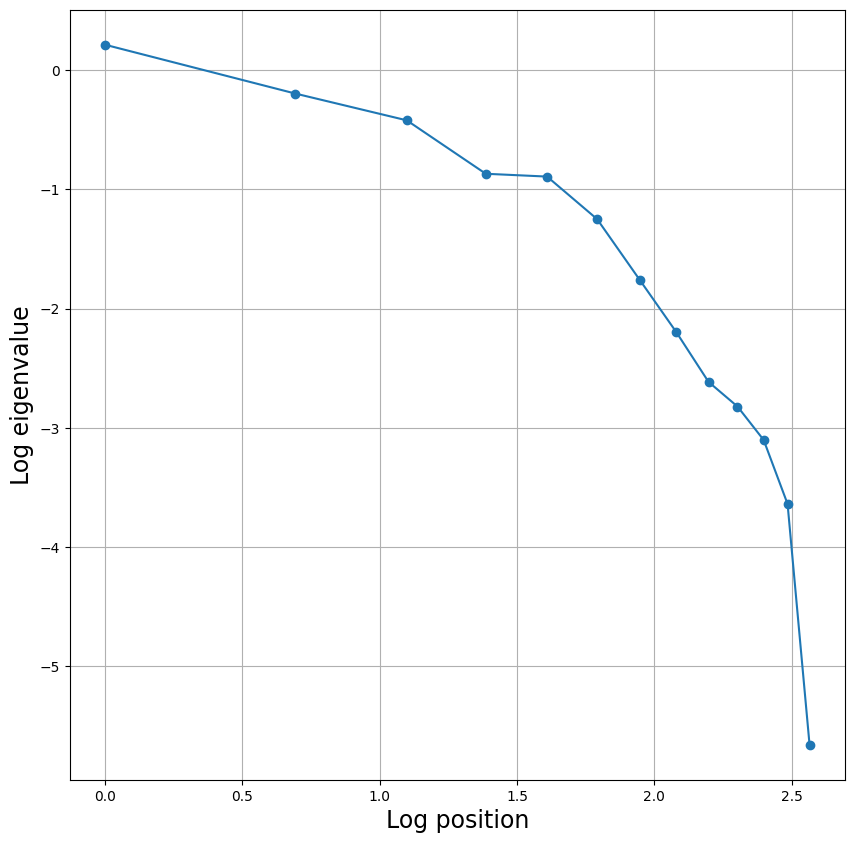

<Figure size 1000x1000 with 0 Axes>

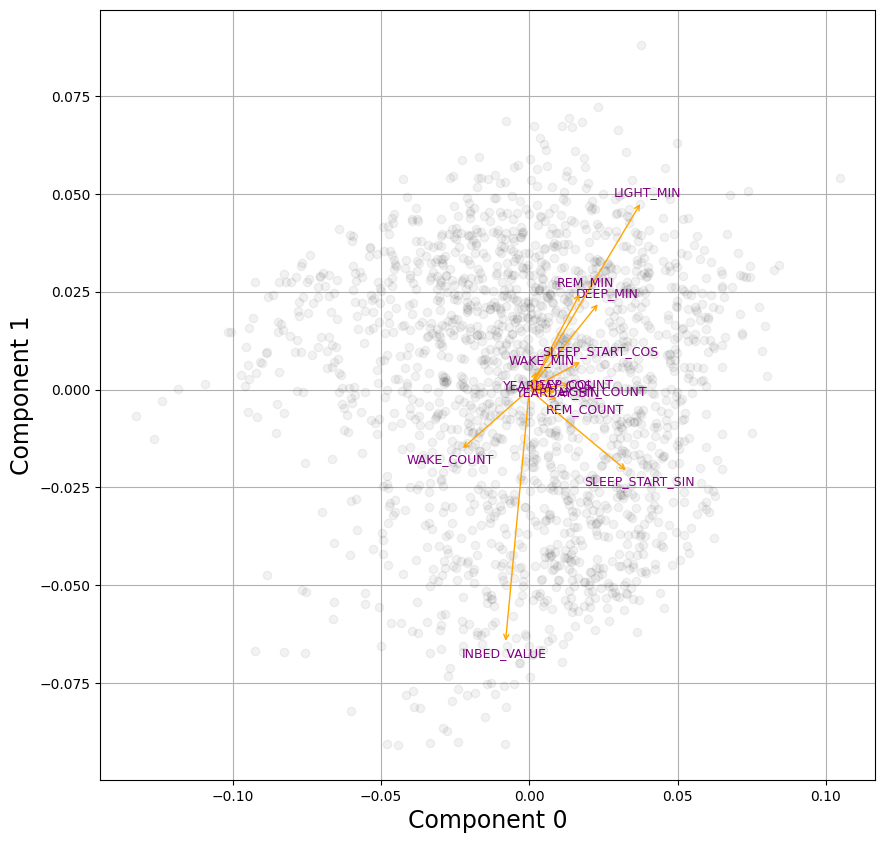

<Figure size 1000x1000 with 0 Axes>

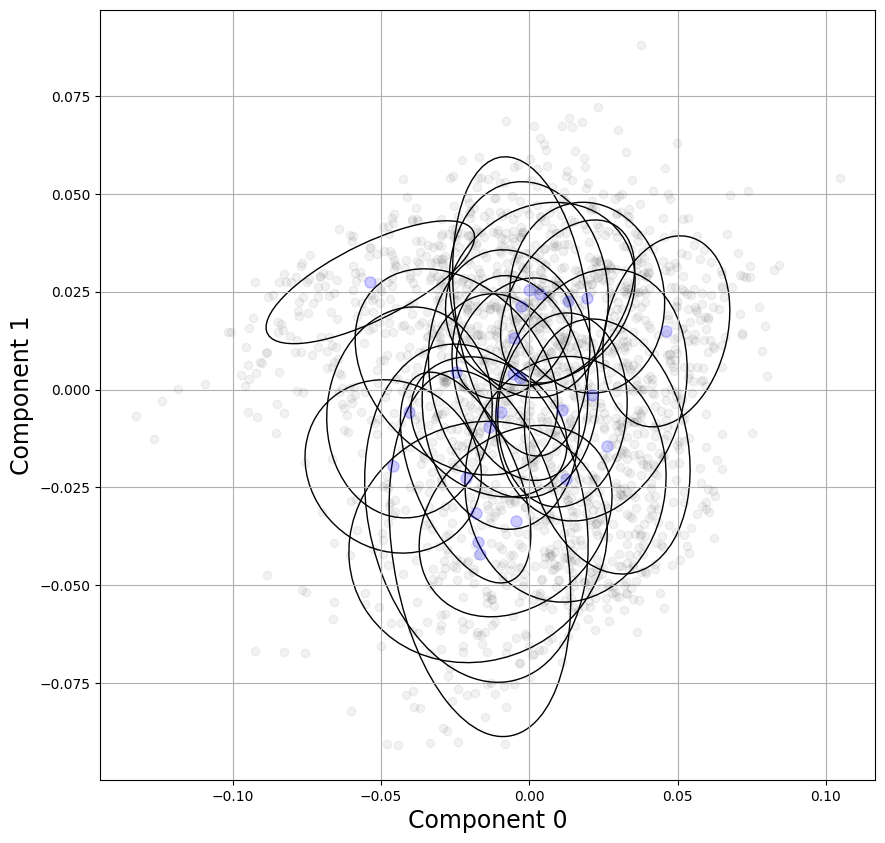

<Figure size 1000x1000 with 0 Axes>

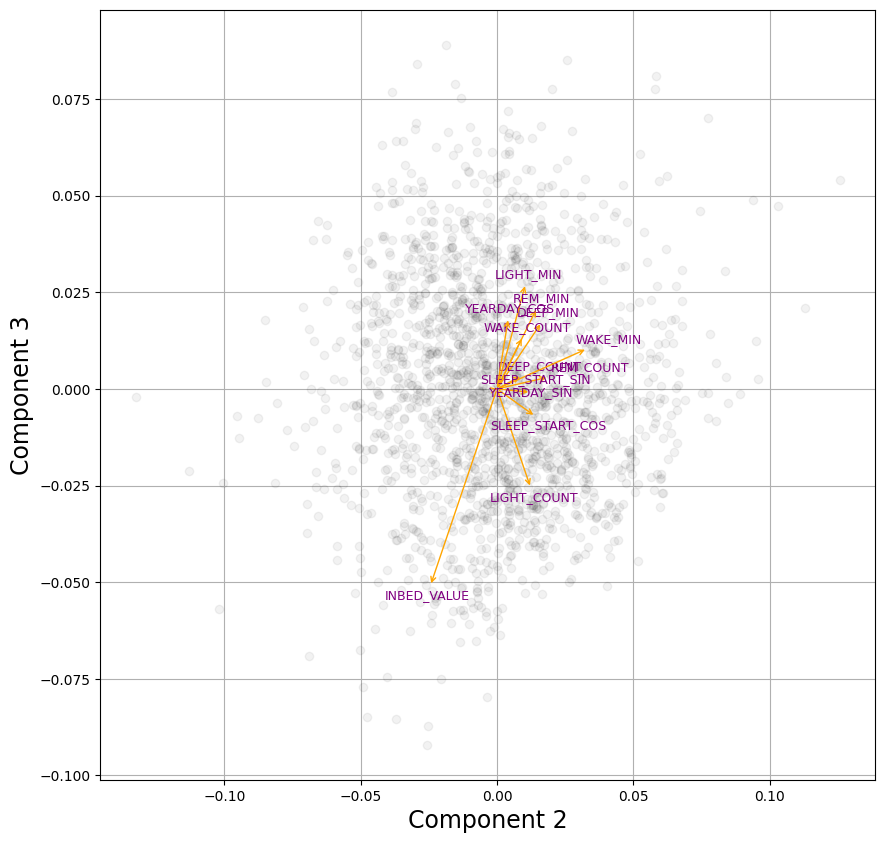

<Figure size 1000x1000 with 0 Axes>

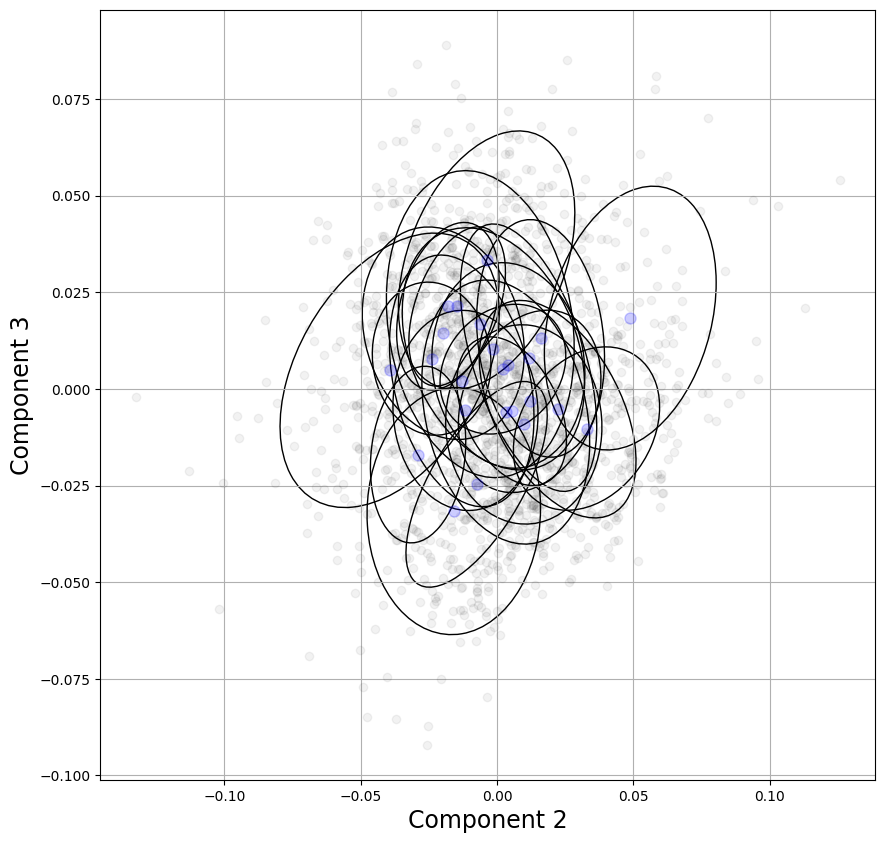

<Figure size 1000x1000 with 0 Axes>

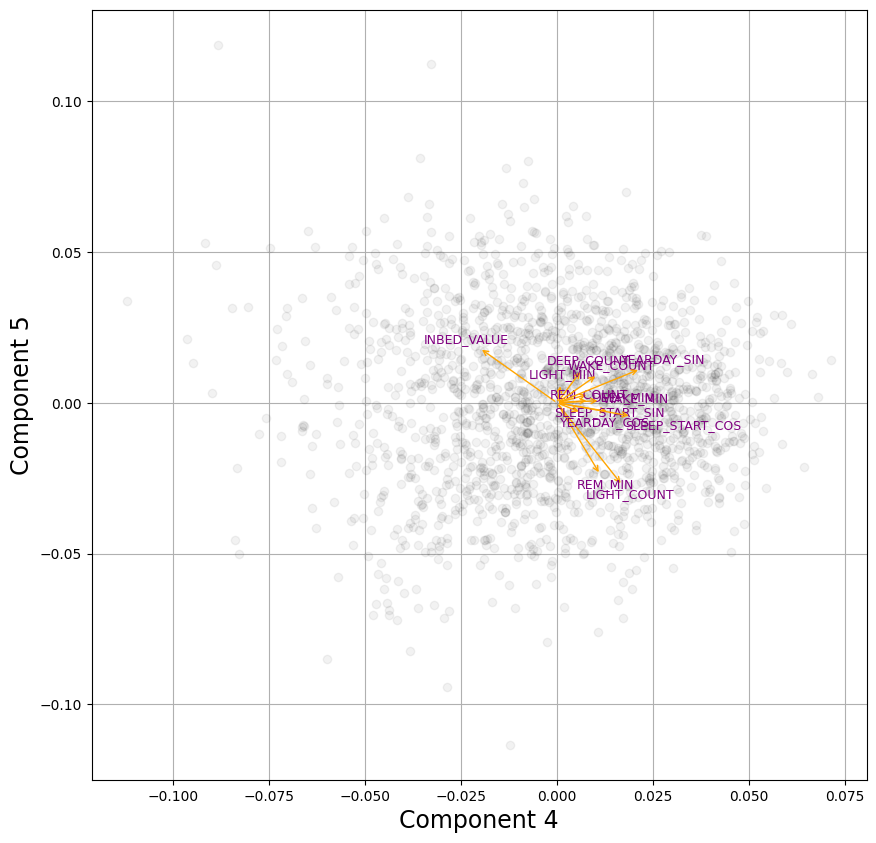

<Figure size 1000x1000 with 0 Axes>

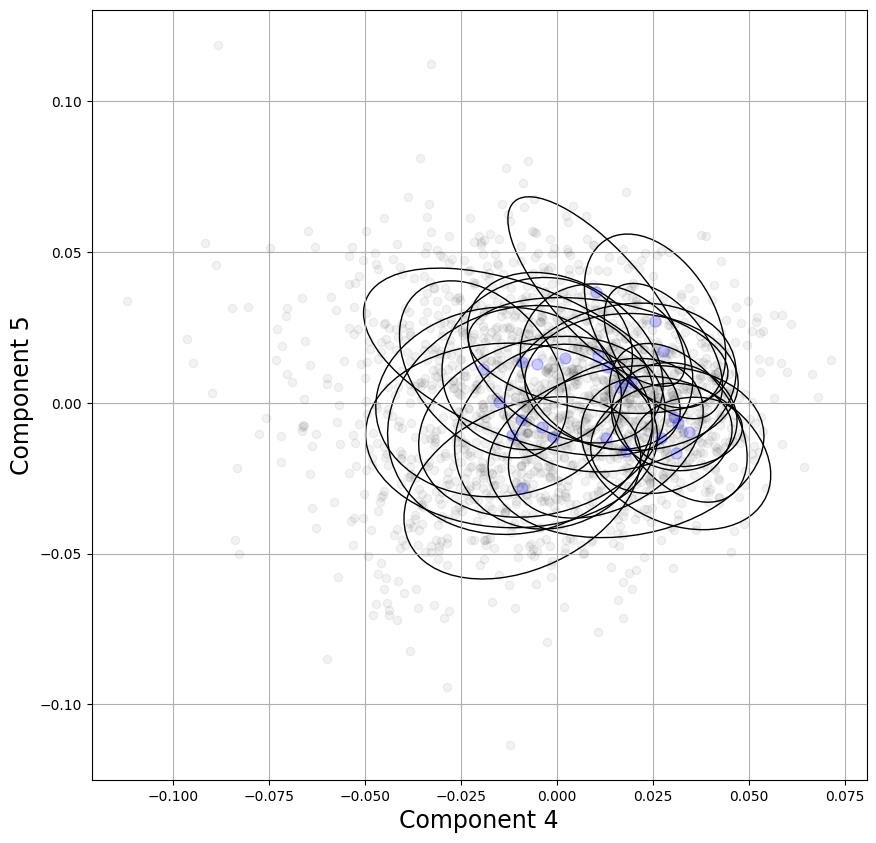

In [20]:
def biplot(j0, j1, X0, B, ee, va, scree=False, ellipses=True):
    scores = np.dot(X0, B[:, [j0, j1]])
    if scree:
        plt.clf()
        plt.grid(True)
        jj = np.arange(1, len(ee)+1)
        plt.plot(np.log(jj), np.log(ee), "-o")
        plt.xlabel("Log position", size=17)
        plt.ylabel("Log eigenvalue", size=17)
        plt.show()
    plt.clf()
    plt.figure(figsize=(10,10))
    plt.grid(True)
    plt.plot(scores[:, 0], scores[:, 1], "o", color="black", alpha=0.05)
    for i in range(B.shape[0]):
        plt.annotate(va[i], xy=(0, 0), xytext=(B[i, j0], B[i, j1]), 
                     arrowprops=dict(color='orange', arrowstyle="<-"), color="purple", size=9)
    plt.xlabel("Component %d" % j0, size=17)
    plt.ylabel("Component %d" % j1, size=17)
    plt.show()

    if ellipses:
        ellipse_plot(scores, dx["STUDY_PRTCPT_ID"], j0, j1)
 
biplot(0, 1, X0, B, ee, va1, scree=True, ellipses=True)
biplot(2, 3, X0, B, ee, va1, ellipses=True)
biplot(4, 5, X0, B, ee, va1, ellipses=True)

# Dimension reduction regression

Use sliced inverse regression to understand the possible roles of day of week, and seasonality

In [21]:
def sir(dx, xv, yv):
    dx = dx.copy()
    dx[xv] = dx[xv] - dx[xv].mean(0)
    C = dx[xv].cov()
    a,_ = eigh(C)
    if a.min() < 1e-10:
        raise ValueError("Marginal covariance of predictors is singular")
    mn, wt = [], []
    for (ky,dg) in dx.groupby(yv):
        mn.append(dg[xv].mean(0))
        wt.append(dg.shape[0])
    M = np.stack(mn)
    wt = np.asarray(wt)
    wt = wt / wt.sum()
    Mw = np.sqrt(wt)[:, None] * M
    H = np.dot(Mw.T, Mw)    
    a, b = eigh(H, C)
    ii = np.argsort(-a)
    a = a[ii]
    b = b[:, ii]
    b = pd.DataFrame(b, columns=["B%d" % j for j in range(len(xv))], index=xv)
    return b, a

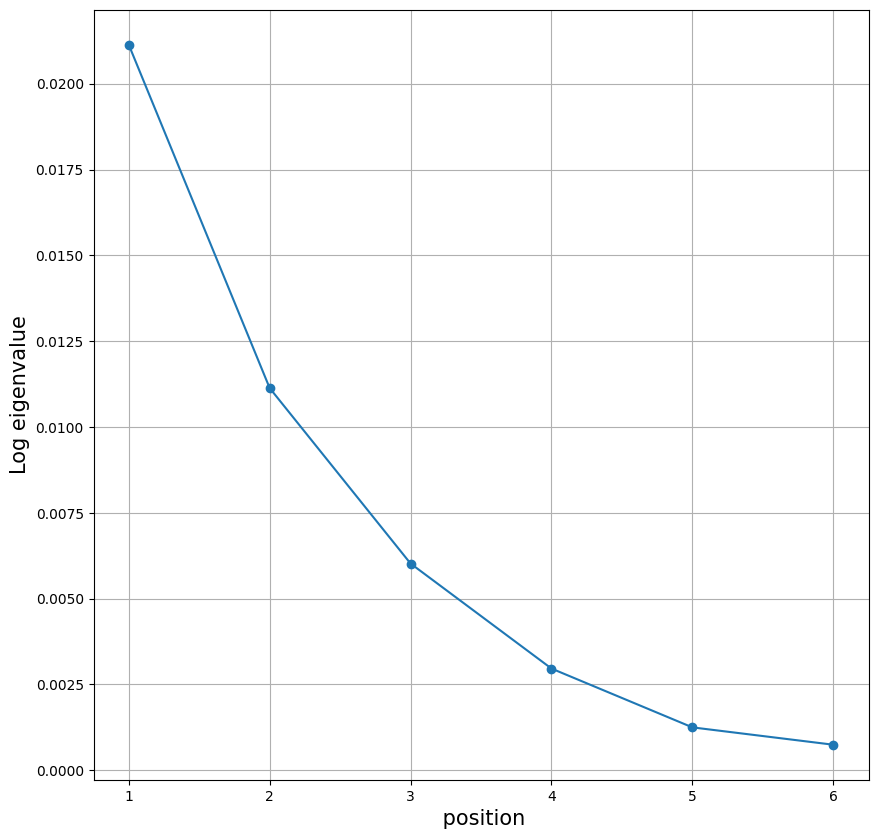

B0        B1        B2        B3
DEEP_MIN        -0.276313 -0.336025  0.049535 -0.814282
DEEP_COUNT      -0.043968 -0.065741 -0.551945  0.614354
LIGHT_MIN       -0.780823  0.566656  0.132988 -0.806060
LIGHT_COUNT      0.299345 -1.687404  0.278425  0.770387
REM_MIN         -0.225339  0.287714  0.483235  0.444029
REM_COUNT       -0.250846 -0.184473 -0.307191  0.472085
WAKE_MIN         0.093375 -0.307738 -0.256573 -0.183555
WAKE_COUNT       0.161767  1.573335  0.524691 -0.339501
SLEEP_START_SIN -0.798979 -0.271314 -0.143101  0.006520
SLEEP_START_COS  0.283516 -0.720659  0.253654  0.088367
YEARDAY_SIN      0.069937 -0.007068  0.398186  0.060111
YEARDAY_COS     -0.088475 -0.079001 -0.379403 -0.372280

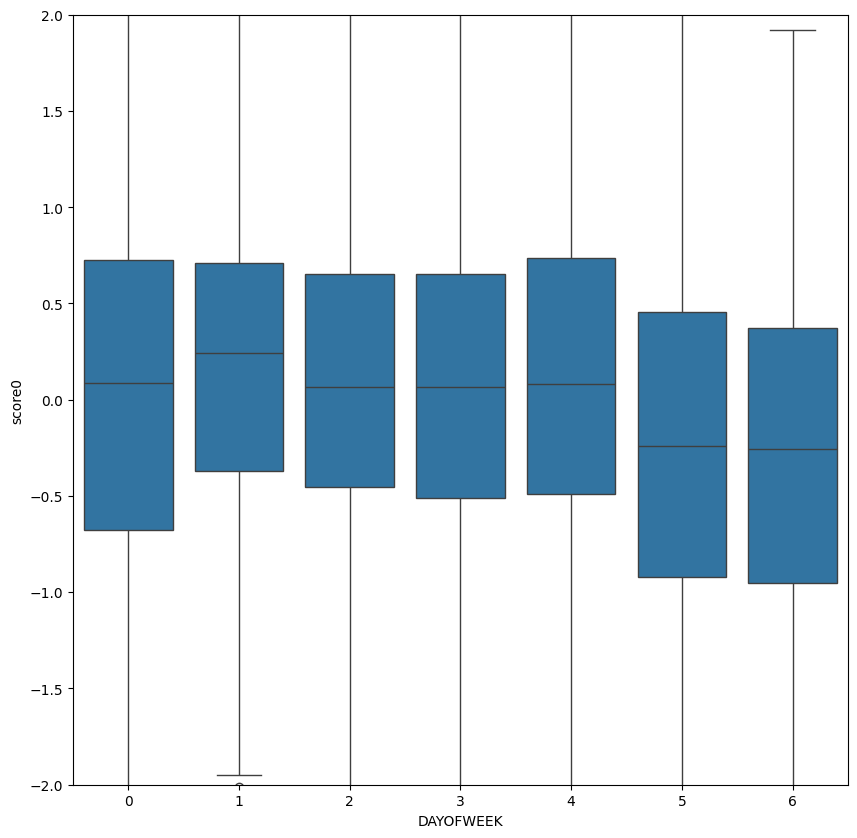

In [22]:
va2 = [x for x in va1 if x != "INBED_VALUE"]

dirs, eigs = sir(dx, va2, "DAYOFWEEK")
plot_eigs(eigs)

dirs.iloc[:, 0:4]
scores = np.dot(dx[va2], dirs.iloc[:, 0:3])

dp = pd.DataFrame({"DAYOFWEEK": dx["DAYOFWEEK"], "score0": scores[:, 0]})
sns.boxplot(dp, x="DAYOFWEEK", y="score0")
plt.ylim(-2, 2)
dirs.iloc[:, 0:4]

C:\Users\rajnishk\AppData\Local\Temp\ipykernel_21308\3073359268.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (ky,dg) in dx.groupby(yv):


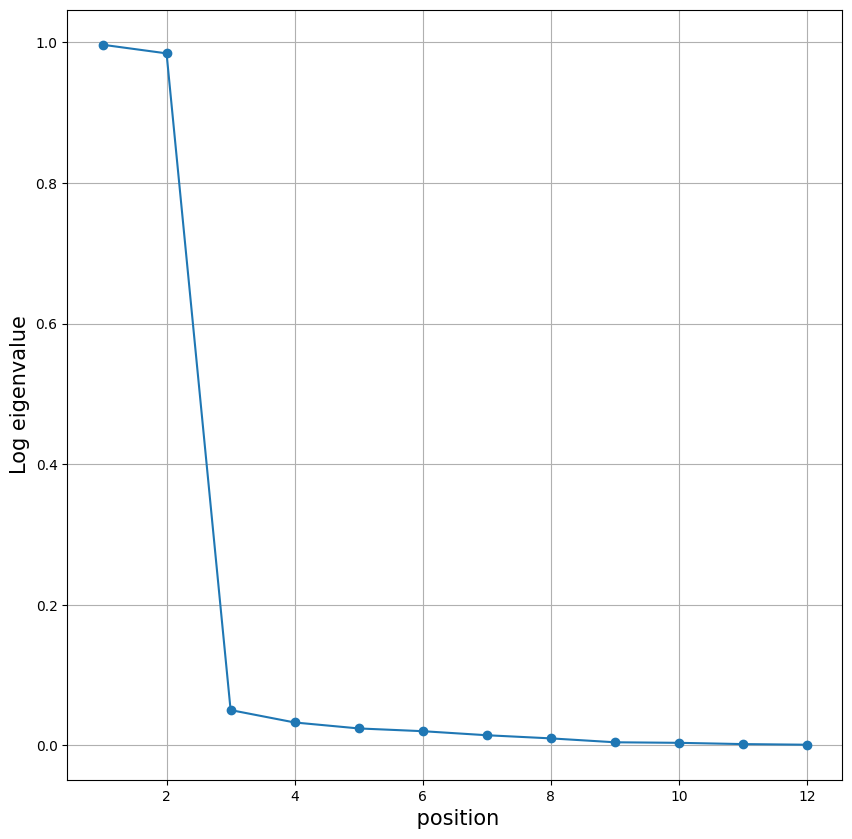

B0        B1        B2        B3
DEEP_MIN         0.000897 -0.007005  0.031807 -0.022978
DEEP_COUNT       0.002158  0.002115 -0.210329  0.146148
LIGHT_MIN        0.004851  0.001988 -0.519427  0.199044
LIGHT_COUNT     -0.008351 -0.001500  0.465218 -0.083895
REM_MIN         -0.000542 -0.000435 -0.673776  0.031049
REM_COUNT        0.000158  0.007286  0.712801 -0.230875
WAKE_MIN         0.003521 -0.008071 -0.126402 -0.836102
WAKE_COUNT       0.002168 -0.000100 -0.430299  0.438332
SLEEP_START_SIN  0.002466 -0.001026  0.508530 -0.217798
SLEEP_START_COS  0.001771  0.002056  0.285742  0.764518
YEARDAY_SIN      0.638666  0.909919 -0.074280  0.082578
YEARDAY_COS      0.539868 -0.971738  0.124053 -0.108734

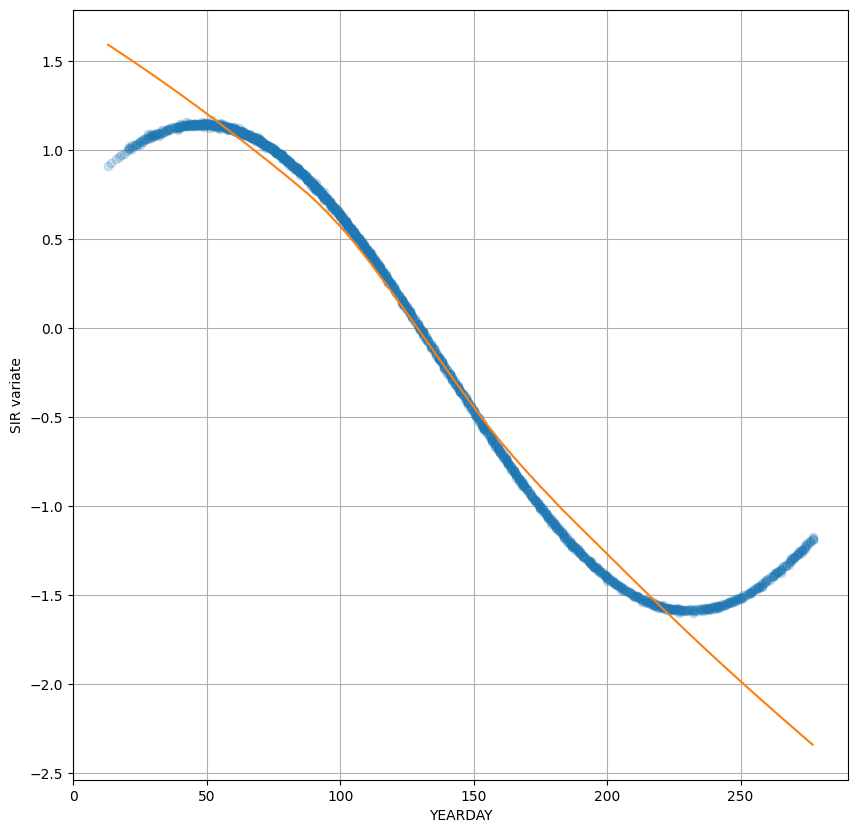

In [23]:
dx["YEARDAYu"] = pd.qcut(dx["YEARDAY"], 20)

dirs, eigs = sir(dx, va2, "YEARDAYu")
plot_eigs(eigs)

scores = np.dot(dx[va2], dirs.iloc[:, 0:3])

xy = lowess(scores[:, 0], dx["YEARDAY"])

plt.clf()
plt.grid(True)
plt.plot(dx["YEARDAY"], scores[:, 0], "o", alpha=0.2)
plt.plot(xy[:, 0], xy[:, 1], "-")
plt.ylabel("SIR variate")
plt.xlabel("YEARDAY")
dirs.iloc[:, 0:4]

# UMAP

This is a very popular modern method but I'm not sure whether it will be useful for us.  It is worth a try.

In [24]:
import umap

um = umap.UMAP(random_state=123)
emb = um.fit_transform(dx[va1])
emb -= emb.mean(0)
emb /= emb.std(0)

C:\Users\rajnishk\AppData\Local\anaconda3\envs\SWG_analysis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\rajnishk\AppData\Local\anaconda3\envs\SWG_analysis\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Color the points by person

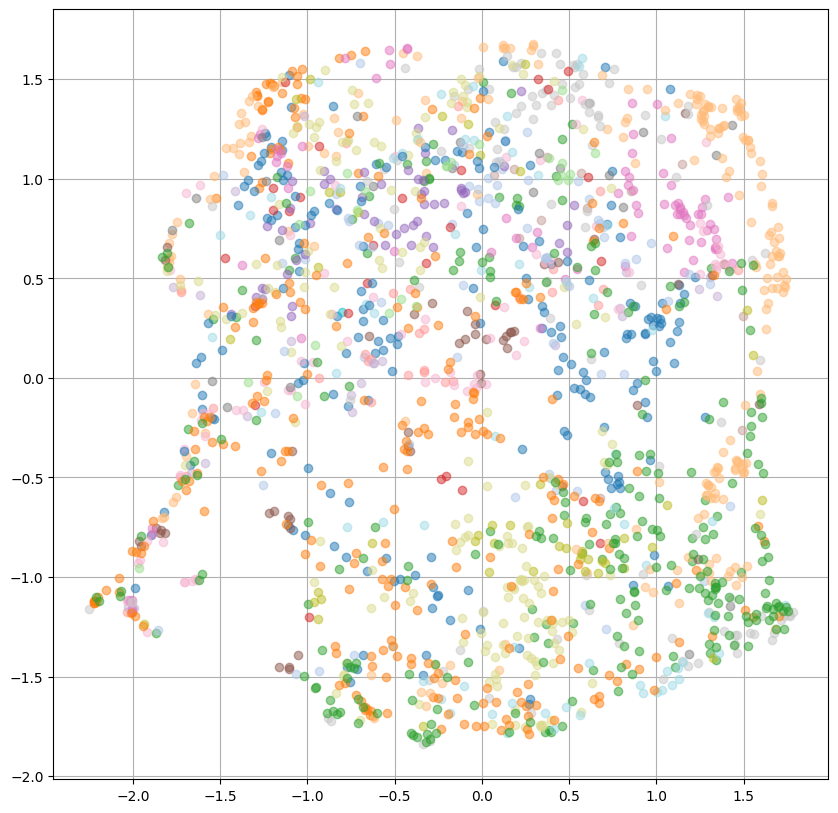

In [25]:
tab20 = matplotlib.colormaps["tab20"].colors
plt.clf()
plt.grid(True)
dp = pd.DataFrame({"id": dx["STUDY_PRTCPT_ID"], "emb0": emb[:, 0], "emb1": emb[:, 1]})
for j,(ky,dg) in enumerate(dp.groupby("id")):
    plt.plot(dg["emb0"], dg["emb1"], "o", alpha=0.5, color=tab20[j % 20])

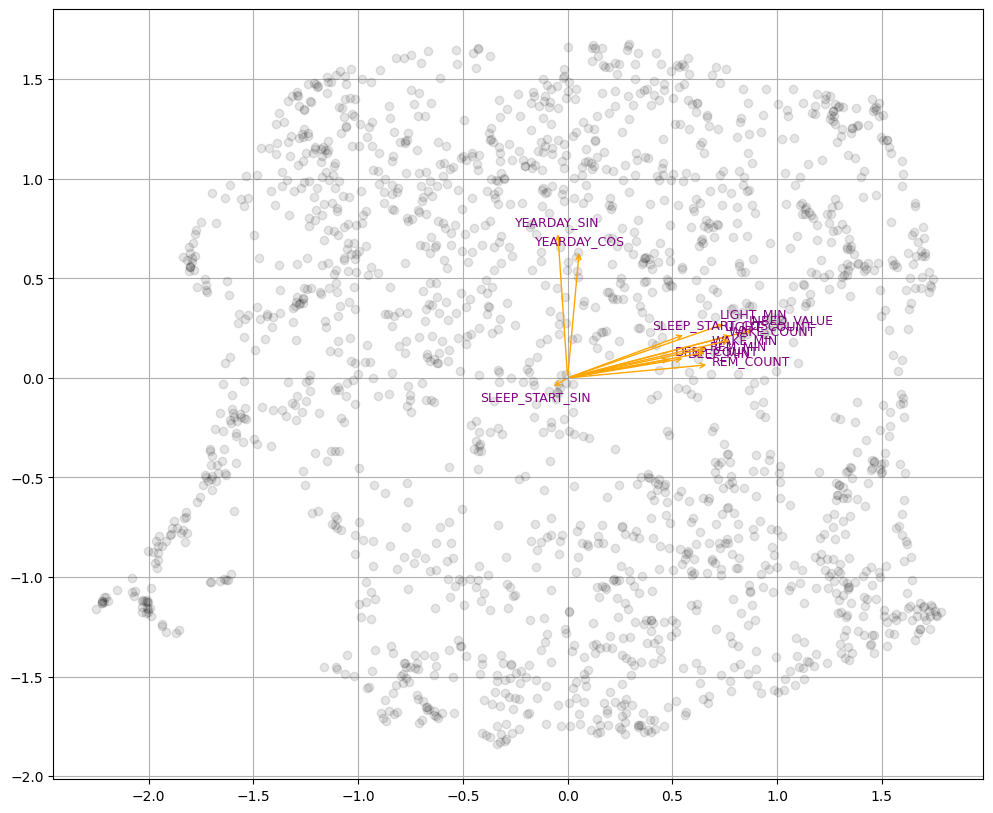

In [26]:
plt.clf
plt.figure(figsize=(12, 10))
plt.grid(True)
plt.plot(emb[:, 0], emb[:, 1], "o", color="black", alpha=0.1)
for v in va1:
    cc = np.linalg.lstsq(emb, dx[v], rcond=None)[0]
    plt.annotate(v, xy=(0, 0), xytext=cc, 
                 arrowprops=dict(color='orange', arrowstyle="<-"), color="purple", size=9)
plt.show()

<Figure size 1000x1000 with 0 Axes>

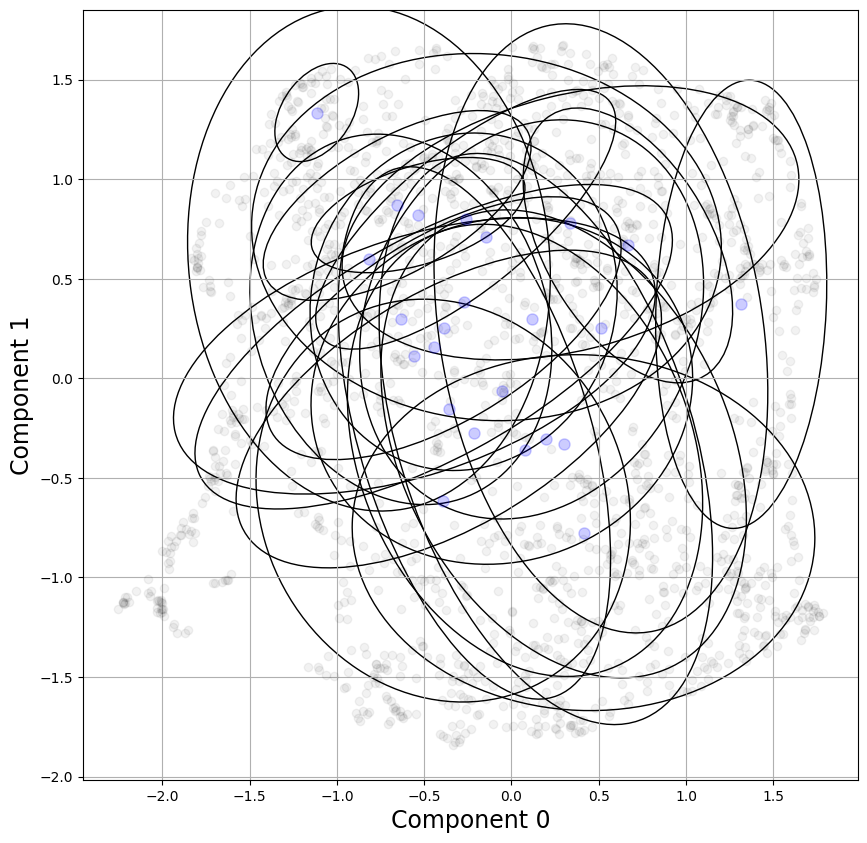

In [27]:
ellipse_plot(emb, dx["STUDY_PRTCPT_ID"], 0, 1)

# CORE

Covariance reduction to identify heteroscedasticity.

In [28]:
tab20 = matplotlib.colormaps["tab20"].colors

In [29]:
nobs = dx["STUDY_PRTCPT_ID"].value_counts()
nobs = pd.DataFrame({"STUDY_PRTCPT_ID": nobs.index, "nobs": nobs.values})
dy = pd.merge(dx, nobs, left_on="STUDY_PRTCPT_ID", right_on="STUDY_PRTCPT_ID")
dy = dy.loc[dy.nobs > 10, :]
idx = np.asarray(dy["STUDY_PRTCPT_ID"].astype(str))
X = np.asarray(dy[va2])
m = CORE(idx, X, 2)
r = m.fit(maxiter=1000)
qq = pd.DataFrame(r.params, va2, columns=["B%d" % j for j in range(2)])
qq

B0        B1
DEEP_MIN         0.002551 -0.020828
DEEP_COUNT      -0.023630  0.000236
LIGHT_MIN        0.022118 -0.064409
LIGHT_COUNT      0.034403 -0.021517
REM_MIN         -0.022962  0.001507
REM_COUNT        0.059187 -0.052341
WAKE_MIN        -0.002742 -0.011259
WAKE_COUNT      -0.018058  0.003159
SLEEP_START_SIN  0.108973 -0.989231
SLEEP_START_COS  0.989842  0.115029
YEARDAY_SIN      0.015121 -0.006310
YEARDAY_COS      0.038824 -0.015037

<Figure size 1000x1000 with 0 Axes>

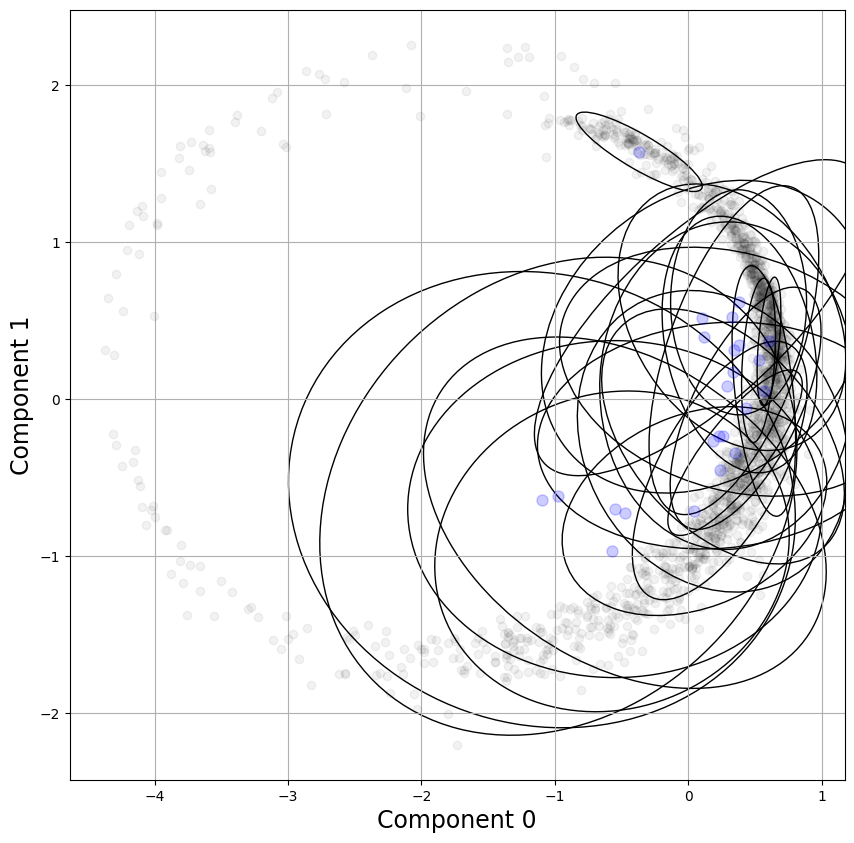

In [30]:
ellipse_plot(np.dot(X, r.params), dy["STUDY_PRTCPT_ID"], 0, 1)